---
# This notebook deals with training a conditional GAN.
- Training a GAN that requires a large dataset of image from which we infer a predicted voxel activity based on our prefered (pre-trained) encoding model.
- We can, as a test, train the GAN while injecting noise with the same statistics as the encoding model's. In this case, we recover no structure and the samples ressemble the training dataset.
---

In [1]:
import sys
import os
import struct
import time
import numpy as np
import h5py
import scipy.io as sio
from scipy import ndimage as nd
from scipy import misc
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import PIL.Image as pim
import seaborn as sns
%matplotlib inline

import theano
import theano.tensor as T

import lasagne
import lasagne.layers as L
import lasagne.regularization as R
import lasagne.nonlinearities as NL
import lasagne.objectives as O
import lasagne.init as I

import src.fwrf as fwrf
from src.fwrf import fpX
import src.numpy_utility as pnu
import src.lasagne_utility as plu
from src.load_data import load_stimuli, load_voxels
from src.load_images import load_cifar10

Using cuDNN version 5103 on context None
Mapped name None to device cuda0: GeForce GTX TITAN X (0000:05:00.0)

theano floatX: float32
numpy floatX: <type 'numpy.float32'>


In [2]:
sns.axes_style()
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 18.0, 'axes.titlesize': 24.0, 'legend.fontsize': 18.0, 'xtick.labelsize': 18.0, 'ytick.labelsize': 18.0})
sns.set_palette("deep")

In [3]:
cwd = os.getcwd() + '/'
output_dir  = cwd + "output/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
result_dir  = cwd + "results/"
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())

print "Current dir: %s" % cwd
print "Time Stamp: %s" % timestamp

Current dir: /home/styvesg/Documents/PostDoc/GitRepo/gan-imaging-clean/
Time Stamp: Aug-21-2019_1956


In [4]:
saveext = ".pdf"
savearg = {'format':'pdf', 'dpi': 200}

# 0) Load CIFAR-10 dataset 

In [5]:
cifar_root = "/home/styvesg/Documents/PostDoc/Datasets/cifar-10/"

In [6]:
input_data, label_data, label_map, input_trn_size = load_cifar10(cifar_root)

input_data_size = len(input_data)
input_trn_size = input_data_size - 500
val_size = input_data_size - input_trn_size

input_data -= 0.5
trn_input_data = input_data[:input_trn_size]
val_input_data = input_data[input_trn_size:] 

trn_label_data = label_data[:input_trn_size]
val_label_data = label_data[input_trn_size:]

print 'min value = ', np.min(trn_input_data), 'max value = ', np.max(trn_input_data)
print trn_input_data.shape
print trn_input_data.dtype

loading data_batch_1...
loading data_batch_2...
loading data_batch_3...
loading data_batch_4...
loading data_batch_5...
loading test_batch...
min value =  -0.5 max value =  0.5
(59500, 3, 32, 32)
float32


In [7]:
print label_map

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [8]:
npc = input_data.shape[1]         # # of channels in image
npx = input_data.shape[2]         # # of pixels width/height of images 
nx = npx*npx*npc   # # of dimensions in X
ny = len(label_map)   # # of classes
print npc, npx, nx, ny

3 32 3072 10


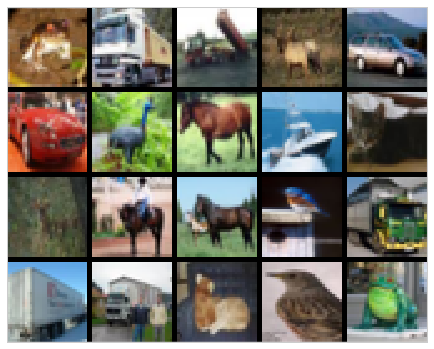

In [9]:
plt.figure(figsize=(10,6))
plt.imshow(pnu.mosaic_vis(input_data[:20,...].transpose(0,2,3,1), pad=2), interpolation='None')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

In [10]:
def entropy(samples, n=2):
    '''
    Estimate the entropy of the sample distribution. Assume pixel n-ary. Estimape p(x_i) from samples.
    samples has dimensions (sample, batch, feature, x, y)
    where batch is different condition
    and sample is diffent sample
    '''
    smin, smax = np.amin(samples), np.amax(samples)
    th = np.clip(((samples-smin)*n/(smax-smin)).astype(int), 0, n-1)
    h = np.zeros(shape=samples.shape[2:])
    for i in range(n):
        prob = np.mean((th==i).astype(np.float32), axis=0) # this sums over the sample dimension
        h += np.mean(prob * np.nan_to_num(np.log2(prob)), axis=(0)) # this sums over the batch
    return -h
   
def average_correlation(samples, reference):
    ac = 0
    for s in samples:
        ac += np.corrcoef(s.flatten(), reference.flatten())[0,1]
    return ac / len(samples)

def emission(prob):
    '''
    generate a sample image from an emission probability map. The color image described by prob results
    from the average of multiple sampling of the prob of emission. Circular.
    '''
    em = np.zeros_like(prob).flatten()
    smin, smax = np.amin(prob), np.amax(prob)
    nprob = (prob-smin)/(smax-smin)
    for i,p in enumerate(nprob.flatten()):
        em[i] = np.random.choice(2, p=[1-p, p])
    return em.reshape(prob.shape)

# Load the classifier network (pre-trained on cifar-10) that formed the basis of the voxel-wise encoding model.
This may not be entirely necessary. There are dozens of trained classification networks out there and we don't need this net to be of the same input size or trained on the same set as we would the GAN (as long as we have multiple resolution of the input)

In [11]:
from net.cifar10_definitions import cls_net, cls_net_str

_X = T.tensor4()
_Y = T.matrix()

cls_input = L.InputLayer(shape=(None, npc, npx, npx), input_var=_X, name='X')
aux, cls = cls_net(cls_input)

plu.print_lasagne_network(cls, skipnoparam=True)
print cls_net_str

Layer	: <lasagne.layers.input.InputLayer object at 0x7f12bc061bd0>
Name	: X
Type	: <class 'lasagne.layers.input.InputLayer'>
Shape	: (None, 3, 32, 32)


Layer	: <lasagne.layers.conv.Conv2DLayer object at 0x7f1318082cd0>
Name	: None
Type	: <class 'lasagne.layers.conv.Conv2DLayer'>
Shape	: (None, 128, 16, 16)
Params
        |-- W         : (128, 3, 4, 4)
        |-- b         : (128,)


Layer	: <lasagne.layers.conv.Conv2DLayer object at 0x7f12b52b6650>
Name	: None
Type	: <class 'lasagne.layers.conv.Conv2DLayer'>
Shape	: (None, 256, 8, 8)
Params
        |-- W         : (256, 128, 4, 4)


Layer	: <lasagne.layers.normalization.BatchNormLayer object at 0x7f1300313890>
Name	: None
Type	: <class 'lasagne.layers.normalization.BatchNormLayer'>
Shape	: (None, 256, 8, 8)
Params
        |-- mean      : (256,)
        |-- inv_std   : (256,)


Layer	: <lasagne.layers.conv.Conv2DLayer object at 0x7f12a965a310>
Name	: None
Type	: <class 'lasagne.layers.conv.Conv2DLayer'>
Shape	: (None, 384, 6, 6)
Param

In [12]:
_cls_val_pred = L.get_output(cls, deterministic=True)
_class = T.extra_ops.to_one_hot(T.argmax(_cls_val_pred, axis=1), ny)
_fmaps = [L.get_output(a, deterministic=True) for a in aux]

print 'COMPILING'
t = time.time()
cls_pred_fn = theano.function([_X], _fmaps+[_class,])
print '%.2f seconds to compile theano functions'%(time.time()-t)

COMPILING
3.85 seconds to compile theano functions


In [13]:
cls_param_file = open(output_dir + "cifar10-cls-128c4s2_256c4s2_384c3_512c3_1024c1_gp_10f-Aug-23-2017_1628.pkl", 'rb')
cls_param_value = pickle.load(cls_param_file)
cls_param_file.close()

L.set_all_param_values(cls, cls_param_value)  
_cls_params = L.get_all_params(cls)

---
## Sanity check
- Parameters should look like wavelet
- Validation score should be around 86%

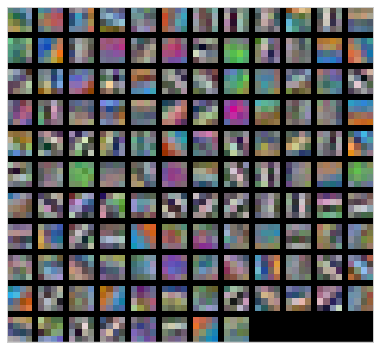

In [14]:
plt.figure(figsize=(10,6))
plt.imshow(pnu.mosaic_vis(_cls_params[0].get_value().transpose(0, 2, 3, 1), pad=1), interpolation='None')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

In [15]:
sample_size = 500
real_X = val_input_data[:sample_size,...]
real_Y = val_label_data[:sample_size,...]

inf = cls_pred_fn(real_X)
inf_fmaps, inf_Y = inf[:-1], inf[-1]

print "Classification accuracy = %f" % (np.mean(np.argmax(inf_Y, axis=1)==np.argmax(real_Y, axis=1)))

Classification accuracy = 0.864000


/usr/local/lib/python2.7/dist-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


---
# Load pre-trained 'voxel prediction' model (subset of best voxels)

In [16]:
import net.cifar10_definitions as net
reload(net)

<module 'net.cifar10_definitions' from 'net/cifar10_definitions.pyc'>

In [17]:
sub_timestamp = 'Aug-19-2019_1823' 
#'Apr-14-2018_1615': with nonlinearity and view_angle=20.
sub_file_name = 'cifar10-auto-linear-%s.pkl' % sub_timestamp

data_file = open(output_dir + "%s" % sub_file_name, 'rb')
sub_dict = pickle.load(data_file)
data_file.close()

print sub_dict.keys()
print sub_dict['fwrf'].keys()
print sub_dict['test'].keys()

['enc', 'noise_corr_matrix', 'voxel_cc', 'mask', 'scale', 'fwrf', 'test_mask', 'test', 'dec']
['rf_params', 'val_cc', 'w_params', 'voxelavg', 'voxelstd']
['gen_voxel_data', 'gen_voxel_pred', 'test_voxel_pred', 'test_stim_data', 'test_voxel_data', 'gen_stim_data']


In [18]:
print [a.shape for a in sub_dict['enc']]

[(2726, 512), (512,), (512, 128), (128,)]


In [19]:
def cc_gain(cc, g):
    a = (fpX(1)-cc)/cc
    return fpX(1)/(fpX(1)+a*np.exp(-g))

from theano.tensor.shared_randomstreams import RandomStreams
def symbolic_per_voxel_correlated_noise_model(_voxels, target_cc, noiseCorrMatrix=None):
    rng = RandomStreams(seed=int(time.time()))
    _noise = rng.normal(size=_voxels.shape)
    if noiseCorrMatrix is not None:
        _noiseCorrMatrix = theano.shared(noiseCorrMatrix.astype(fpX))
        _noise = T.tensordot(_noise, _noiseCorrMatrix, [[1], [1]])
    _cc = T.patternbroadcast(theano.shared(target_cc.astype(fpX)[np.newaxis,:]), (True, False))
    _delta, _epsilon = _cc, T.sqrt((fpX(1) - T.sqr(_cc))) 
    return _voxels * _delta + _noise * _epsilon, _cc

### Create a forward-only fwrf model with the pretrained weights and params. Only predict best voxels (we may have to select the best voxel based on a hold-out on the training set instead of the validation set, to make sure the validation set never touch the model)

In [20]:
nv = len(sub_dict['voxel_cc'])
_fmaps      = [L.get_output(a, deterministic=True) for a in aux]
fmaps_sizes = [f.shape for f in inf_fmaps]

_log_act_func = lambda _x: T.log(1+T.sqrt(T.abs_(_x)))
_Vbar, _VbarSharedVar = fwrf.get_symbolic_prediction(_fmaps, fmaps_sizes, sub_dict['fwrf']['rf_params'], sub_dict['fwrf']['w_params'],\
    sub_dict['fwrf']['voxelavg'], sub_dict['fwrf']['voxelstd'], view_angle=1.0, _nonlinearity=_log_act_func)
Vbar_fn = theano.function([_X], _Vbar)
###
_V = T.matrix()
#_Vsynth, _voxel_cc = symbolic_per_voxel_correlated_noise_model(_V, sub_dict['voxel_cc'])
_Vsynth, _voxel_cc = symbolic_per_voxel_correlated_noise_model(_V, sub_dict['voxel_cc'], sub_dict['noise_corr_matrix'])
Vsynth_fn = theano.function([_V], _Vsynth)

CREATING SYMBOLS

> feature map candidates 0 with shape (2726, 1, 16, 16)
> feature map candidates 1 with shape (2726, 1, 8, 8)
> feature map candidates 2 with shape (2726, 1, 6, 6)
> feature map candidates 3 with shape (2726, 1, 4, 4)
> feature map candidates 4 with shape (2726, 1, 4, 4)
> feature map candidates 5 with shape (2726, 1, 1, 1)
  total number of feature maps = 2314, in 6 layers
  feature map candidate using approx 4.0 Mb of memory (VRAM and RAM)


## Generate synthetic voxel response corresponding to the CIFAR-10 set (training and test). 

In [21]:
voxel_synth_pred = np.ndarray(shape=(input_data_size, nv), dtype=fpX)
batch_size = 100

b = 0
for xb,_ in tqdm(fwrf.iterate_minibatches(input_data, label_data, batch_size)):
    voxel_synth_pred[b*batch_size:(b+1)*batch_size,:] = Vbar_fn(xb)
    b += 1
# z-score
voxel_synth_pred_avgs = np.mean(voxel_synth_pred[:input_trn_size], axis=0)
voxel_synth_pred_stds = np.std(voxel_synth_pred[:input_trn_size], axis=0)
voxel_synth_pred = (voxel_synth_pred - voxel_synth_pred_avgs) / voxel_synth_pred_stds

trn_voxel_synth_pred = voxel_synth_pred[:input_trn_size] 
val_voxel_synth_pred = voxel_synth_pred[input_trn_size:]
# add noise model to create the fake data from the prediction

600it [04:59,  2.00it/s]


# Load the pre-trained 'embedding' encoder model

In [22]:
from net.cifar10_definitions import enc_net, dec_net

_enc_input = L.InputLayer(shape=(None, nv), input_var=_V, name='V')
_enc = enc_net(_enc_input, output_channels=len(sub_dict['enc'][-1]), drop_rate=0., nonlinearity=NL.sigmoid)
L.set_all_param_values(_enc, sub_dict['enc'])

_enc_synth = L.get_output(_enc, inputs=_Vsynth, deterministic=True)
_enc_true  = L.get_output(_enc, inputs=_V, deterministic=True)

enc_synth = theano.function([_V], _enc_synth)
enc_true  = theano.function([_V], _enc_true)

## Display an example of the mean and variance of the embedding across samples of the encoding model

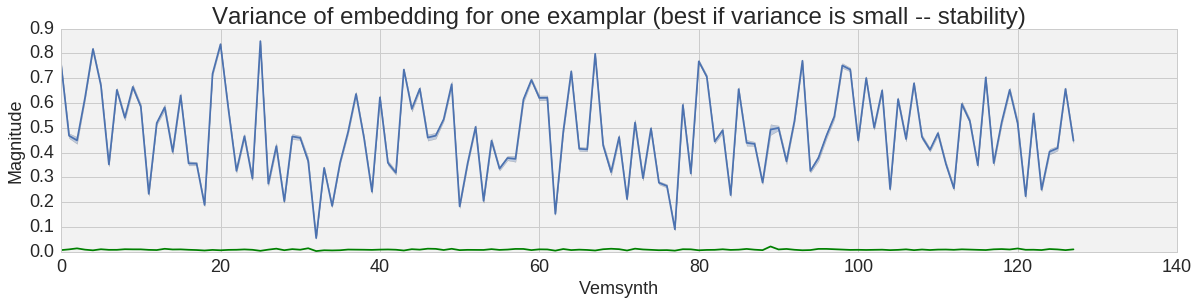

In [23]:
rep = np.repeat(val_voxel_synth_pred[1:2], repeats=10000, axis=0)
Vemsynth = enc_synth(rep)
Vemsynth_avg = np.mean(Vemsynth, axis=0)
Vemsynth_std = np.std(Vemsynth, axis=0)

fig_3 = plt.figure(figsize=(20,4))
plt.title('Variance of embedding for one examplar (best if variance is small -- stability)')
plt.plot(Vemsynth_avg)
plt.fill_between(np.arange(len(Vemsynth_avg)), Vemsynth_avg-Vemsynth_std, Vemsynth_avg+Vemsynth_std, alpha=0.3)
plt.plot(Vemsynth_std, 'g')
plt.xlabel('Vemsynth')
plt.ylabel('Magnitude')

## Display an example of the mean and variance of the embedding across samples in the dataset.

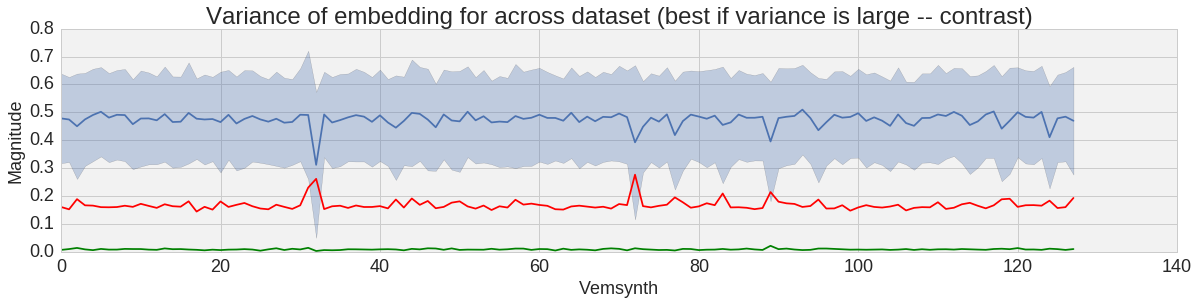

In [24]:
Vemsynth_std_1 = np.copy(Vemsynth_std)
Vemsynth = enc_synth(val_voxel_synth_pred[:10000])
Vemsynth_avg = np.mean(Vemsynth, axis=0)
Vemsynth_std = np.std(Vemsynth, axis=0)

fig_4 = plt.figure(figsize=(20,4))
plt.title('Variance of embedding for across dataset (best if variance is large -- contrast)')
plt.plot(Vemsynth_avg)
plt.fill_between(np.arange(len(Vemsynth_avg)), Vemsynth_avg-Vemsynth_std, Vemsynth_avg+Vemsynth_std, alpha=0.3)

plt.plot(Vemsynth_std_1, 'g')
plt.plot(Vemsynth_std, 'r')
plt.xlabel('Vemsynth')
plt.ylabel('Magnitude')

# Define the Conditonal EB-GAN architecture

## Conditional genarator network

In [25]:
z_dist = pnu.normal_ncube
num_noise_slices = [256, 8, 4, 2, 0]

nc = Vemsynth.shape[1]
nz = 920     # # of dim for Z
_Z = T.matrix()
_C = _enc_synth

from net.cifar10_definitions import cond_gen_net, cond_erg_enc_net, cond_erg_dec_net, cond_gen_net_str

seed = L.InputLayer((None, nz), input_var=_Z, name='Z')
cond = L.InputLayer((None, nc), input_var=_C, name='C')
gen = cond_gen_net(seed, cond, num_noise_slices=num_noise_slices)
#plu.print_lasagne_network(gen, skipnoparam=True)

===> graph requires nz>=920 <===


## Conditional energy-based autoencoder discriminator network

In [26]:
#_erg_input = L.InputLayer(shape=(None, npc, npx, npx), input_var=_X, name='X')
#
#_erg, _embs = net.cond_erg_auto_resnet(_erg_input, _cond, noise_sigma=0.02, drop_ratio_conv=0.1)
#_emb = _embs[0]

erg_input = L.InputLayer(shape=(None, npc, npx, npx), input_var=_X, name='X')

emb = cond_erg_enc_net(erg_input, cond)
erg = cond_erg_dec_net(emb, cond)
#plu.print_lasagne_network(erg, skipnoparam=True)

## EBGAN Training compile

In [29]:
_dlr = theano.shared(fpX(0))
_glr = theano.shared(fpX(0))
_dl2 = theano.shared(fpX(0))
_gl2 = theano.shared(fpX(0))
_pt = theano.shared(fpX(0.1))
_Em = theano.shared(fpX(1.0))

igZ, lgZ = plu.get_layer(gen, 'Z')
igC, lgC = plu.get_layer(gen, 'C')
_gen_trn = L.get_output(gen, inputs={lgZ:_Z, lgC:_C}, deterministic=False)
_gen_synth = L.get_output(gen, inputs={lgZ:_Z, lgC:_C}, deterministic=True)
_gen_true = L.get_output(gen, inputs={lgZ:_Z, lgC:_enc_true}, deterministic=True)
_gen_reg = _gl2 * R.regularize_layer_params(gen, R.l2)
gen_params = L.get_all_params(gen, trainable=True)
print gen_params

idX, ldX = plu.get_layer(erg, 'X')
idC, ldC = plu.get_layer(erg, 'C')
_erg_trn = L.get_output(erg, inputs={ldX:_X, ldC:_C}, deterministic=False)
_erg_reg = _dl2 * R.regularize_layer_params(erg, R.l2)
erg_params = L.get_all_params(erg, trainable=True)
print erg_params

##### WILL HAVE TO BE CAREFUL: THIS IS VALID AS LONG AS THE NETWORK TOPOLOGY DOESN'T CHANGE THE ORDER OF THE INPUTS ####
_foo_trn = L.get_output(erg, inputs={ldX:_gen_trn, ldC:_C}, deterministic=False)

idX, ldX = plu.get_layer(emb, 'X')
_emb_trn = L.get_output(emb, inputs={ldX:_gen_trn}, deterministic=False)
_pt_loss = plu.pullaway_loss(T.flatten(_emb_trn, ndim=2))

# This is really annoying: after reading lots of other people's code, I still can't determine
# what is the correct normalization of the relative loss versus the hyperparameter values.
# It's a mess out there.
#
_d_cost_real = (O.squared_error(_erg_trn, _X).mean(axis=(1,2,3))).mean()
_g_cost_d_b = (O.squared_error(_foo_trn, _gen_trn).mean(axis=(1,2,3))).dimshuffle((0, 'x'))
_d_cost_g   = T.max(T.concatenate([-_g_cost_d_b + _Em, T.zeros(shape=_g_cost_d_b.shape)], axis=1), axis=1).mean()
_g_cost_d   = _g_cost_d_b.mean()

_d_cost = _d_cost_real + _d_cost_g #+ _dis_reg
_g_cost = _g_cost_d + _pt*_pt_loss #+ _gen_reg

_cost = [_g_cost, _d_cost, _g_cost_d, _d_cost_real, _d_cost_g, _pt_loss]

d_updates = lasagne.updates.adam(_d_cost, erg_params, learning_rate=_dlr, beta1=0.5, epsilon=1e-6) 
g_updates = lasagne.updates.adam(_g_cost, gen_params, learning_rate=_glr, beta1=0.5, epsilon=1e-6) 

print '\nCOMPILING'
t = time.time()
train_d = theano.function([_X, _Z, _V], _cost, updates=d_updates)
train_g = theano.function([_X, _Z, _V], _cost, updates=g_updates)
gen_synth = theano.function([_Z, _V], _gen_synth)
gen_true = theano.function([_Z, _V], _gen_true) 
print '%.2f seconds to compile theano functions'%(time.time()-t)

[W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W]
[W, beta, gamma, W, beta, gamma, W, b, W, b]

COMPILING
15.14 seconds to compile theano functions


## EBGAN training

In [30]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    '''
    for a given 4d input image tensor and a 2d target tensor of one-hot embedding, 
    return a shuffled batch of input-target pair
    '''
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [31]:
dlr = fpX(5.0e-4) # 5.0e-4       # initial learning rate for adam
glr = fpX(2.5e-4) # 2.5e-4

k = 1
niter_bckup = 100
niter = 250       # # of iter at starting learning rate
perc_decay = 1.  # # percentage decay every niter iterations
num_epochs = 400
batch_size = 500
training_dir = cwd + "training/"
params_dir = cwd + "temp/"
if not os.path.exists(training_dir):
    os.makedirs(training_dir)
if not os.path.exists(params_dir):
    os.makedirs(params_dir)
sample_size = 20

_dlr.set_value(dlr)
_glr.set_value(glr)

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_batches = 1
    start_time = time.time()
    #for xb, yb, vb in tqdm(pnu.iterate_minibatches_aux(inputData[:trn_size], labelData[:trn_size], voxelPred[:trn_size], batch_size, shuffle=True)):  
    for xb, vb in tqdm(iterate_minibatches(trn_input_data, trn_voxel_synth_pred, batch_size, True)):    
        zb = z_dist(batch_size, nz)
        #vb = z_dist(batch_size, nv) #### replace voxel with normal noise
        if train_batches % (k+1) == 0:
            costs = train_g(xb, zb, vb)
        else:
            costs = train_d(xb, zb, vb)
        train_batches += 1
       
    # Then we print the results for this epoch:
    print("\nEpoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("Costs: g=%.3f, d=%.3f, [dgz]=%.3f, [dx]=%.3f, [m-dgz]=%.3f, [pt]=%.3f") % (costs[0],costs[1],costs[2],costs[3],costs[4], costs[5])
       
    ##################################################################
    idx = np.random.randint(0, val_size-sample_size)
    real_X = val_input_data[idx:idx+sample_size]   
    synth_V = val_voxel_synth_pred[idx:idx+sample_size]
    #synth_V = z_dist(sample_size, nv) ####
    sample_Z = z_dist(sample_size, nz)
    
    sample_X = gen_synth(sample_Z, synth_V)

    fig = plt.figure(figsize=(20,8))
    plt.subplot(1,2,1)
    plt.imshow(pnu.mosaic_vis(real_X.transpose(0,2,3,1), pad=2), interpolation='None')
    plt.grid('off')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.subplot(1,2,2)
    plt.imshow(pnu.mosaic_vis(sample_X.transpose(0,2,3,1), pad=2), interpolation='None')
    plt.grid('off')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)    
    fig.savefig(training_dir + "sample_%04d.png" % epoch)
    plt.close()
    ##################################################################
    
    # save the state of the net in a new file every N iteration
    if (epoch + 1)%niter_bckup==0:
        gen_param_file = open(params_dir + "gan_params_epoch_%d" % epoch, 'wb')
        gen_param_values = {'gen': L.get_all_param_values(gen),\
                            'erg': L.get_all_param_values(erg),\
                            'noise_slices': num_noise_slices}
        pickle.dump(gen_param_values, gen_param_file)
        gen_param_file.close()    

    if epoch > niter:
        _dlr.set_value(fpX(_dlr.get_value() * (1.0 - perc_decay / 100.0)))    
        _glr.set_value(fpX(_glr.get_value() * (1.0 - perc_decay / 100.0)))     
    sys.stdout.flush()

119it [01:09,  1.68it/s]


Epoch 1 of 400 took 69.441s
Costs: g=0.824, d=0.514, [dgz]=0.775, [dx]=0.247, [m-dgz]=0.267, [pt]=0.490



119it [01:09,  1.68it/s]


Epoch 2 of 400 took 69.568s
Costs: g=0.866, d=0.738, [dgz]=0.822, [dx]=0.440, [m-dgz]=0.298, [pt]=0.437



119it [01:09,  1.68it/s]


Epoch 3 of 400 took 69.672s
Costs: g=0.867, d=0.615, [dgz]=0.823, [dx]=0.380, [m-dgz]=0.235, [pt]=0.439



119it [01:09,  1.67it/s]


Epoch 4 of 400 took 69.670s
Costs: g=1.264, d=0.544, [dgz]=1.217, [dx]=0.466, [m-dgz]=0.078, [pt]=0.468



119it [01:09,  1.67it/s]


Epoch 5 of 400 took 69.787s
Costs: g=0.673, d=0.742, [dgz]=0.628, [dx]=0.346, [m-dgz]=0.396, [pt]=0.448



119it [01:09,  1.67it/s]


Epoch 6 of 400 took 69.820s
Costs: g=0.822, d=0.718, [dgz]=0.779, [dx]=0.419, [m-dgz]=0.298, [pt]=0.437



119it [01:09,  1.67it/s]


Epoch 7 of 400 took 69.882s
Costs: g=0.363, d=0.965, [dgz]=0.325, [dx]=0.289, [m-dgz]=0.676, [pt]=0.381



119it [01:09,  1.67it/s]


Epoch 8 of 400 took 69.843s
Costs: g=0.338, d=0.999, [dgz]=0.300, [dx]=0.299, [m-dgz]=0.701, [pt]=0.379



119it [01:09,  1.68it/s]


Epoch 9 of 400 took 69.931s
Costs: g=0.686, d=0.875, [dgz]=0.652, [dx]=0.445, [m-dgz]=0.430, [pt]=0.344



119it [01:09,  1.67it/s]


Epoch 10 of 400 took 69.885s
Costs: g=0.537, d=0.886, [dgz]=0.502, [dx]=0.373, [m-dgz]=0.513, [pt]=0.347



119it [01:09,  1.67it/s]


Epoch 11 of 400 took 69.929s
Costs: g=0.504, d=0.862, [dgz]=0.469, [dx]=0.322, [m-dgz]=0.540, [pt]=0.348



119it [01:09,  1.67it/s]


Epoch 12 of 400 took 69.926s
Costs: g=0.641, d=0.877, [dgz]=0.607, [dx]=0.461, [m-dgz]=0.415, [pt]=0.347



119it [01:09,  1.67it/s]


Epoch 13 of 400 took 69.948s
Costs: g=0.426, d=0.938, [dgz]=0.395, [dx]=0.317, [m-dgz]=0.621, [pt]=0.308



119it [01:09,  1.67it/s]


Epoch 14 of 400 took 69.967s
Costs: g=0.897, d=0.670, [dgz]=0.866, [dx]=0.486, [m-dgz]=0.184, [pt]=0.311



119it [01:09,  1.67it/s]


Epoch 15 of 400 took 69.960s
Costs: g=0.660, d=0.900, [dgz]=0.631, [dx]=0.491, [m-dgz]=0.409, [pt]=0.292



119it [01:10,  1.66it/s]


Epoch 16 of 400 took 70.029s
Costs: g=0.486, d=0.986, [dgz]=0.456, [dx]=0.438, [m-dgz]=0.548, [pt]=0.301



119it [01:10,  1.67it/s]


Epoch 17 of 400 took 70.044s
Costs: g=0.805, d=0.840, [dgz]=0.776, [dx]=0.525, [m-dgz]=0.315, [pt]=0.297



119it [01:09,  1.67it/s]


Epoch 18 of 400 took 69.947s
Costs: g=0.560, d=0.881, [dgz]=0.528, [dx]=0.381, [m-dgz]=0.500, [pt]=0.323



119it [01:10,  1.67it/s]


Epoch 19 of 400 took 70.006s
Costs: g=0.536, d=0.896, [dgz]=0.507, [dx]=0.382, [m-dgz]=0.514, [pt]=0.286



119it [01:09,  1.67it/s]


Epoch 20 of 400 took 69.934s
Costs: g=0.446, d=1.079, [dgz]=0.416, [dx]=0.481, [m-dgz]=0.598, [pt]=0.299



119it [01:10,  1.67it/s]


Epoch 21 of 400 took 70.009s
Costs: g=0.472, d=0.836, [dgz]=0.444, [dx]=0.271, [m-dgz]=0.565, [pt]=0.283



119it [01:10,  1.66it/s]


Epoch 22 of 400 took 70.029s
Costs: g=0.569, d=0.892, [dgz]=0.542, [dx]=0.410, [m-dgz]=0.482, [pt]=0.271



119it [01:09,  1.66it/s]


Epoch 23 of 400 took 69.956s
Costs: g=0.643, d=0.792, [dgz]=0.615, [dx]=0.347, [m-dgz]=0.444, [pt]=0.278



119it [01:09,  1.67it/s]


Epoch 24 of 400 took 69.968s
Costs: g=0.781, d=0.807, [dgz]=0.755, [dx]=0.470, [m-dgz]=0.337, [pt]=0.263



119it [01:09,  1.67it/s]


Epoch 25 of 400 took 69.998s
Costs: g=0.697, d=0.884, [dgz]=0.672, [dx]=0.499, [m-dgz]=0.386, [pt]=0.252



119it [01:09,  1.67it/s]


Epoch 26 of 400 took 69.994s
Costs: g=0.515, d=0.923, [dgz]=0.489, [dx]=0.364, [m-dgz]=0.560, [pt]=0.264



119it [01:09,  1.67it/s]


Epoch 27 of 400 took 69.983s
Costs: g=0.593, d=0.867, [dgz]=0.566, [dx]=0.407, [m-dgz]=0.459, [pt]=0.264



119it [01:10,  1.66it/s]


Epoch 28 of 400 took 70.043s
Costs: g=0.680, d=0.828, [dgz]=0.653, [dx]=0.444, [m-dgz]=0.384, [pt]=0.273



119it [01:09,  1.67it/s]


Epoch 29 of 400 took 69.972s
Costs: g=0.817, d=0.894, [dgz]=0.793, [dx]=0.590, [m-dgz]=0.304, [pt]=0.239



119it [01:10,  1.67it/s]


Epoch 30 of 400 took 70.025s
Costs: g=0.421, d=1.030, [dgz]=0.397, [dx]=0.424, [m-dgz]=0.605, [pt]=0.245



119it [01:09,  1.67it/s]


Epoch 31 of 400 took 69.972s
Costs: g=0.675, d=0.928, [dgz]=0.651, [dx]=0.539, [m-dgz]=0.389, [pt]=0.241



119it [01:10,  1.66it/s]


Epoch 32 of 400 took 70.018s
Costs: g=0.686, d=0.839, [dgz]=0.661, [dx]=0.476, [m-dgz]=0.363, [pt]=0.251



119it [01:10,  1.67it/s]


Epoch 33 of 400 took 70.058s
Costs: g=0.819, d=0.761, [dgz]=0.792, [dx]=0.471, [m-dgz]=0.290, [pt]=0.262



119it [01:10,  1.66it/s]


Epoch 34 of 400 took 70.069s
Costs: g=0.685, d=0.870, [dgz]=0.661, [dx]=0.508, [m-dgz]=0.362, [pt]=0.240



119it [01:10,  1.66it/s]


Epoch 35 of 400 took 70.020s
Costs: g=0.449, d=0.866, [dgz]=0.424, [dx]=0.289, [m-dgz]=0.577, [pt]=0.246



119it [01:10,  1.67it/s]


Epoch 36 of 400 took 70.020s
Costs: g=0.490, d=0.892, [dgz]=0.467, [dx]=0.354, [m-dgz]=0.538, [pt]=0.237



119it [01:10,  1.67it/s]


Epoch 37 of 400 took 70.054s
Costs: g=0.646, d=0.894, [dgz]=0.623, [dx]=0.497, [m-dgz]=0.397, [pt]=0.230



119it [01:10,  1.66it/s]


Epoch 38 of 400 took 70.015s
Costs: g=0.655, d=0.981, [dgz]=0.631, [dx]=0.592, [m-dgz]=0.389, [pt]=0.235



119it [01:10,  1.66it/s]


Epoch 39 of 400 took 70.008s
Costs: g=0.600, d=0.917, [dgz]=0.577, [dx]=0.477, [m-dgz]=0.439, [pt]=0.228



119it [01:09,  1.66it/s]


Epoch 40 of 400 took 69.987s
Costs: g=0.517, d=0.959, [dgz]=0.494, [dx]=0.447, [m-dgz]=0.512, [pt]=0.227



119it [01:09,  1.66it/s]


Epoch 41 of 400 took 69.980s
Costs: g=0.638, d=0.946, [dgz]=0.616, [dx]=0.550, [m-dgz]=0.396, [pt]=0.226



119it [01:09,  1.67it/s]


Epoch 42 of 400 took 69.971s
Costs: g=0.634, d=0.888, [dgz]=0.612, [dx]=0.488, [m-dgz]=0.400, [pt]=0.221



119it [01:09,  1.67it/s]


Epoch 43 of 400 took 69.980s
Costs: g=0.798, d=0.758, [dgz]=0.772, [dx]=0.476, [m-dgz]=0.282, [pt]=0.260



119it [01:09,  1.68it/s]


Epoch 44 of 400 took 69.973s
Costs: g=0.576, d=0.871, [dgz]=0.554, [dx]=0.415, [m-dgz]=0.456, [pt]=0.223



119it [01:10,  1.66it/s]


Epoch 45 of 400 took 70.031s
Costs: g=0.617, d=0.962, [dgz]=0.596, [dx]=0.553, [m-dgz]=0.409, [pt]=0.213



119it [01:10,  1.66it/s]


Epoch 46 of 400 took 70.060s
Costs: g=0.492, d=0.918, [dgz]=0.471, [dx]=0.384, [m-dgz]=0.534, [pt]=0.206



119it [01:09,  1.67it/s]


Epoch 47 of 400 took 69.982s
Costs: g=0.586, d=0.942, [dgz]=0.565, [dx]=0.494, [m-dgz]=0.448, [pt]=0.215



119it [01:10,  1.66it/s]


Epoch 48 of 400 took 70.041s
Costs: g=0.660, d=0.993, [dgz]=0.638, [dx]=0.609, [m-dgz]=0.384, [pt]=0.216



119it [01:10,  1.67it/s]


Epoch 49 of 400 took 70.056s
Costs: g=0.694, d=0.936, [dgz]=0.673, [dx]=0.579, [m-dgz]=0.356, [pt]=0.213



119it [01:10,  1.67it/s]


Epoch 50 of 400 took 70.095s
Costs: g=0.670, d=0.896, [dgz]=0.649, [dx]=0.533, [m-dgz]=0.363, [pt]=0.213



119it [01:10,  1.67it/s]


Epoch 51 of 400 took 70.049s
Costs: g=0.638, d=0.924, [dgz]=0.619, [dx]=0.532, [m-dgz]=0.393, [pt]=0.191



119it [01:10,  1.67it/s]


Epoch 52 of 400 took 70.075s
Costs: g=0.710, d=0.844, [dgz]=0.690, [dx]=0.510, [m-dgz]=0.335, [pt]=0.201



119it [01:10,  1.66it/s]


Epoch 53 of 400 took 70.098s
Costs: g=0.418, d=0.931, [dgz]=0.397, [dx]=0.323, [m-dgz]=0.608, [pt]=0.210



119it [01:10,  1.66it/s]


Epoch 54 of 400 took 70.071s
Costs: g=0.740, d=0.894, [dgz]=0.719, [dx]=0.589, [m-dgz]=0.305, [pt]=0.212



119it [01:10,  1.67it/s]


Epoch 55 of 400 took 70.068s
Costs: g=0.596, d=0.948, [dgz]=0.576, [dx]=0.500, [m-dgz]=0.448, [pt]=0.195



119it [01:10,  1.66it/s]


Epoch 56 of 400 took 70.034s
Costs: g=0.813, d=0.829, [dgz]=0.793, [dx]=0.581, [m-dgz]=0.248, [pt]=0.192



119it [01:10,  1.67it/s]


Epoch 57 of 400 took 70.033s
Costs: g=0.714, d=0.876, [dgz]=0.694, [dx]=0.546, [m-dgz]=0.330, [pt]=0.198



119it [01:10,  1.66it/s]


Epoch 58 of 400 took 70.020s
Costs: g=0.492, d=0.917, [dgz]=0.473, [dx]=0.387, [m-dgz]=0.530, [pt]=0.191



119it [01:10,  1.66it/s]


Epoch 59 of 400 took 70.026s
Costs: g=0.603, d=0.903, [dgz]=0.584, [dx]=0.469, [m-dgz]=0.434, [pt]=0.190



119it [01:10,  1.67it/s]


Epoch 60 of 400 took 70.041s
Costs: g=0.655, d=0.940, [dgz]=0.636, [dx]=0.557, [m-dgz]=0.383, [pt]=0.189



119it [01:09,  1.66it/s]


Epoch 61 of 400 took 69.990s
Costs: g=0.610, d=0.978, [dgz]=0.592, [dx]=0.555, [m-dgz]=0.423, [pt]=0.183



119it [01:09,  1.66it/s]


Epoch 62 of 400 took 69.987s
Costs: g=0.623, d=0.917, [dgz]=0.604, [dx]=0.501, [m-dgz]=0.416, [pt]=0.196



119it [01:10,  1.67it/s]


Epoch 63 of 400 took 70.004s
Costs: g=0.918, d=0.863, [dgz]=0.899, [dx]=0.668, [m-dgz]=0.195, [pt]=0.200



119it [01:09,  1.66it/s]


Epoch 64 of 400 took 69.981s
Costs: g=0.681, d=0.964, [dgz]=0.661, [dx]=0.609, [m-dgz]=0.355, [pt]=0.198



119it [01:10,  1.67it/s]


Epoch 65 of 400 took 70.007s
Costs: g=0.666, d=0.902, [dgz]=0.648, [dx]=0.536, [m-dgz]=0.366, [pt]=0.183



119it [01:09,  1.67it/s]


Epoch 66 of 400 took 69.971s
Costs: g=0.672, d=0.921, [dgz]=0.654, [dx]=0.559, [m-dgz]=0.363, [pt]=0.181



119it [01:10,  1.66it/s]


Epoch 67 of 400 took 70.005s
Costs: g=0.604, d=0.923, [dgz]=0.585, [dx]=0.499, [m-dgz]=0.424, [pt]=0.195



119it [01:10,  1.66it/s]


Epoch 68 of 400 took 70.023s
Costs: g=0.747, d=0.870, [dgz]=0.729, [dx]=0.579, [m-dgz]=0.292, [pt]=0.177



119it [01:10,  1.67it/s]


Epoch 69 of 400 took 70.016s
Costs: g=0.584, d=0.890, [dgz]=0.567, [dx]=0.451, [m-dgz]=0.439, [pt]=0.170



119it [01:09,  1.66it/s]


Epoch 70 of 400 took 69.993s
Costs: g=1.693, d=0.584, [dgz]=1.670, [dx]=0.548, [m-dgz]=0.036, [pt]=0.225



119it [01:09,  1.67it/s]


Epoch 71 of 400 took 69.970s
Costs: g=0.631, d=0.963, [dgz]=0.609, [dx]=0.554, [m-dgz]=0.408, [pt]=0.220



119it [01:09,  1.67it/s]


Epoch 72 of 400 took 69.960s
Costs: g=2.055, d=0.618, [dgz]=2.033, [dx]=0.612, [m-dgz]=0.006, [pt]=0.224



119it [01:09,  1.67it/s]


Epoch 73 of 400 took 69.968s
Costs: g=0.526, d=0.696, [dgz]=0.506, [dx]=0.199, [m-dgz]=0.497, [pt]=0.203



119it [01:09,  1.67it/s]


Epoch 74 of 400 took 69.971s
Costs: g=0.399, d=0.879, [dgz]=0.375, [dx]=0.253, [m-dgz]=0.626, [pt]=0.236



119it [01:10,  1.66it/s]


Epoch 75 of 400 took 70.035s
Costs: g=1.518, d=0.339, [dgz]=1.495, [dx]=0.287, [m-dgz]=0.053, [pt]=0.229



119it [01:09,  1.66it/s]


Epoch 76 of 400 took 69.953s
Costs: g=0.868, d=0.628, [dgz]=0.846, [dx]=0.345, [m-dgz]=0.284, [pt]=0.222



119it [01:09,  1.67it/s]


Epoch 77 of 400 took 69.948s
Costs: g=0.480, d=0.719, [dgz]=0.459, [dx]=0.176, [m-dgz]=0.543, [pt]=0.207



119it [01:09,  1.66it/s]


Epoch 78 of 400 took 69.990s
Costs: g=1.190, d=0.306, [dgz]=1.167, [dx]=0.175, [m-dgz]=0.131, [pt]=0.225



119it [01:09,  1.67it/s]


Epoch 79 of 400 took 69.897s
Costs: g=0.665, d=0.547, [dgz]=0.642, [dx]=0.130, [m-dgz]=0.417, [pt]=0.235



119it [01:10,  1.66it/s]


Epoch 80 of 400 took 70.022s
Costs: g=0.504, d=0.860, [dgz]=0.482, [dx]=0.334, [m-dgz]=0.526, [pt]=0.221



119it [01:09,  1.67it/s]


Epoch 81 of 400 took 69.986s
Costs: g=3.436, d=0.487, [dgz]=3.412, [dx]=0.484, [m-dgz]=0.003, [pt]=0.239



119it [01:09,  1.67it/s]


Epoch 82 of 400 took 69.987s
Costs: g=2.209, d=0.418, [dgz]=2.188, [dx]=0.415, [m-dgz]=0.003, [pt]=0.213



119it [01:09,  1.67it/s]


Epoch 83 of 400 took 69.957s
Costs: g=0.294, d=0.877, [dgz]=0.272, [dx]=0.149, [m-dgz]=0.728, [pt]=0.220



119it [01:09,  1.67it/s]


Epoch 84 of 400 took 69.984s
Costs: g=0.672, d=0.690, [dgz]=0.650, [dx]=0.298, [m-dgz]=0.392, [pt]=0.218



119it [01:09,  1.67it/s]


Epoch 85 of 400 took 69.989s
Costs: g=0.600, d=0.615, [dgz]=0.579, [dx]=0.177, [m-dgz]=0.438, [pt]=0.217



119it [01:09,  1.67it/s]


Epoch 86 of 400 took 69.938s
Costs: g=0.887, d=0.572, [dgz]=0.865, [dx]=0.315, [m-dgz]=0.257, [pt]=0.218



119it [01:09,  1.67it/s]


Epoch 87 of 400 took 69.938s
Costs: g=1.282, d=0.410, [dgz]=1.259, [dx]=0.272, [m-dgz]=0.138, [pt]=0.230



119it [01:09,  1.67it/s]


Epoch 88 of 400 took 69.901s
Costs: g=0.497, d=0.614, [dgz]=0.474, [dx]=0.080, [m-dgz]=0.535, [pt]=0.224



119it [01:09,  1.67it/s]


Epoch 89 of 400 took 69.942s
Costs: g=1.532, d=0.228, [dgz]=1.509, [dx]=0.099, [m-dgz]=0.129, [pt]=0.230



119it [01:09,  1.67it/s]


Epoch 90 of 400 took 69.923s
Costs: g=0.736, d=0.742, [dgz]=0.714, [dx]=0.401, [m-dgz]=0.341, [pt]=0.213



119it [01:09,  1.67it/s]


Epoch 91 of 400 took 69.942s
Costs: g=1.618, d=0.403, [dgz]=1.596, [dx]=0.349, [m-dgz]=0.055, [pt]=0.220



119it [01:09,  1.67it/s]


Epoch 92 of 400 took 69.969s
Costs: g=0.742, d=0.886, [dgz]=0.719, [dx]=0.565, [m-dgz]=0.320, [pt]=0.228



119it [01:10,  1.66it/s]


Epoch 93 of 400 took 70.037s
Costs: g=0.844, d=0.835, [dgz]=0.822, [dx]=0.616, [m-dgz]=0.219, [pt]=0.220



119it [01:09,  1.67it/s]


Epoch 94 of 400 took 69.979s
Costs: g=0.722, d=0.834, [dgz]=0.702, [dx]=0.520, [m-dgz]=0.313, [pt]=0.202



119it [01:10,  1.67it/s]


Epoch 95 of 400 took 70.016s
Costs: g=0.750, d=0.801, [dgz]=0.730, [dx]=0.511, [m-dgz]=0.290, [pt]=0.201



119it [01:09,  1.67it/s]


Epoch 96 of 400 took 69.968s
Costs: g=0.843, d=0.812, [dgz]=0.823, [dx]=0.578, [m-dgz]=0.234, [pt]=0.198



119it [01:09,  1.66it/s]


Epoch 97 of 400 took 69.982s
Costs: g=0.765, d=0.841, [dgz]=0.745, [dx]=0.564, [m-dgz]=0.276, [pt]=0.197



119it [01:10,  1.66it/s]


Epoch 98 of 400 took 70.038s
Costs: g=0.624, d=0.819, [dgz]=0.605, [dx]=0.417, [m-dgz]=0.402, [pt]=0.187



119it [01:10,  1.67it/s]


Epoch 99 of 400 took 70.011s
Costs: g=0.730, d=0.834, [dgz]=0.711, [dx]=0.516, [m-dgz]=0.317, [pt]=0.187



119it [01:10,  1.66it/s]


Epoch 100 of 400 took 70.051s
Costs: g=0.770, d=0.866, [dgz]=0.751, [dx]=0.583, [m-dgz]=0.283, [pt]=0.191



119it [01:09,  1.67it/s]


Epoch 101 of 400 took 69.987s
Costs: g=0.986, d=0.277, [dgz]=0.965, [dx]=0.108, [m-dgz]=0.169, [pt]=0.207



119it [01:09,  1.66it/s]


Epoch 102 of 400 took 69.957s
Costs: g=0.924, d=0.830, [dgz]=0.903, [dx]=0.640, [m-dgz]=0.190, [pt]=0.214



119it [01:10,  1.67it/s]


Epoch 103 of 400 took 70.008s
Costs: g=0.790, d=0.825, [dgz]=0.771, [dx]=0.564, [m-dgz]=0.261, [pt]=0.190



119it [01:09,  1.67it/s]


Epoch 104 of 400 took 69.963s
Costs: g=0.927, d=0.764, [dgz]=0.908, [dx]=0.554, [m-dgz]=0.209, [pt]=0.198



119it [01:09,  1.66it/s]


Epoch 105 of 400 took 69.987s
Costs: g=0.607, d=0.821, [dgz]=0.589, [dx]=0.401, [m-dgz]=0.419, [pt]=0.184



119it [01:09,  1.67it/s]


Epoch 106 of 400 took 69.968s
Costs: g=0.550, d=0.879, [dgz]=0.533, [dx]=0.398, [m-dgz]=0.481, [pt]=0.173



119it [01:09,  1.67it/s]


Epoch 107 of 400 took 69.907s
Costs: g=0.913, d=0.757, [dgz]=0.893, [dx]=0.566, [m-dgz]=0.191, [pt]=0.198



119it [01:10,  1.66it/s]


Epoch 108 of 400 took 70.018s
Costs: g=0.714, d=0.815, [dgz]=0.696, [dx]=0.491, [m-dgz]=0.324, [pt]=0.185



119it [01:09,  1.66it/s]


Epoch 109 of 400 took 69.923s
Costs: g=0.910, d=0.437, [dgz]=0.892, [dx]=0.225, [m-dgz]=0.212, [pt]=0.179



119it [01:09,  1.67it/s]


Epoch 110 of 400 took 69.920s
Costs: g=0.857, d=0.802, [dgz]=0.835, [dx]=0.565, [m-dgz]=0.237, [pt]=0.215



119it [01:10,  1.66it/s]


Epoch 111 of 400 took 70.022s
Costs: g=0.921, d=0.852, [dgz]=0.900, [dx]=0.667, [m-dgz]=0.184, [pt]=0.202



119it [01:10,  1.67it/s]


Epoch 112 of 400 took 70.018s
Costs: g=0.742, d=0.785, [dgz]=0.723, [dx]=0.486, [m-dgz]=0.298, [pt]=0.186



119it [01:09,  1.67it/s]


Epoch 113 of 400 took 69.984s
Costs: g=0.716, d=0.800, [dgz]=0.698, [dx]=0.475, [m-dgz]=0.325, [pt]=0.182



119it [01:10,  1.67it/s]


Epoch 114 of 400 took 70.010s
Costs: g=0.804, d=0.804, [dgz]=0.786, [dx]=0.550, [m-dgz]=0.254, [pt]=0.179



119it [01:09,  1.67it/s]


Epoch 115 of 400 took 69.949s
Costs: g=3.309, d=0.569, [dgz]=3.291, [dx]=0.569, [m-dgz]=0.000, [pt]=0.185



119it [01:09,  1.67it/s]


Epoch 116 of 400 took 69.970s
Costs: g=5.362, d=0.158, [dgz]=5.341, [dx]=0.158, [m-dgz]=0.000, [pt]=0.211



119it [01:10,  1.66it/s]


Epoch 117 of 400 took 70.043s
Costs: g=0.796, d=0.852, [dgz]=0.777, [dx]=0.582, [m-dgz]=0.270, [pt]=0.199



119it [01:10,  1.67it/s]


Epoch 118 of 400 took 70.061s
Costs: g=0.761, d=0.784, [dgz]=0.743, [dx]=0.503, [m-dgz]=0.281, [pt]=0.179



119it [01:09,  1.67it/s]


Epoch 119 of 400 took 69.931s
Costs: g=0.860, d=0.820, [dgz]=0.841, [dx]=0.617, [m-dgz]=0.203, [pt]=0.186



119it [01:10,  1.66it/s]


Epoch 120 of 400 took 70.021s
Costs: g=0.682, d=0.788, [dgz]=0.664, [dx]=0.438, [m-dgz]=0.350, [pt]=0.177



119it [01:10,  1.67it/s]


Epoch 121 of 400 took 70.011s
Costs: g=0.709, d=0.813, [dgz]=0.692, [dx]=0.484, [m-dgz]=0.329, [pt]=0.174



119it [01:09,  1.67it/s]


Epoch 122 of 400 took 69.997s
Costs: g=0.815, d=0.805, [dgz]=0.798, [dx]=0.566, [m-dgz]=0.239, [pt]=0.172



119it [01:10,  1.67it/s]


Epoch 123 of 400 took 70.007s
Costs: g=0.677, d=0.777, [dgz]=0.659, [dx]=0.421, [m-dgz]=0.356, [pt]=0.172



119it [01:10,  1.67it/s]


Epoch 124 of 400 took 70.004s
Costs: g=0.699, d=0.811, [dgz]=0.682, [dx]=0.471, [m-dgz]=0.340, [pt]=0.169



119it [01:10,  1.67it/s]


Epoch 125 of 400 took 70.044s
Costs: g=1.046, d=0.742, [dgz]=1.029, [dx]=0.608, [m-dgz]=0.134, [pt]=0.171



119it [01:09,  1.67it/s]


Epoch 126 of 400 took 69.973s
Costs: g=0.682, d=0.548, [dgz]=0.663, [dx]=0.167, [m-dgz]=0.381, [pt]=0.189



119it [01:10,  1.66it/s]


Epoch 127 of 400 took 70.052s
Costs: g=4.715, d=0.792, [dgz]=4.695, [dx]=0.792, [m-dgz]=0.000, [pt]=0.205



119it [01:09,  1.66it/s]


Epoch 128 of 400 took 69.919s
Costs: g=0.645, d=0.828, [dgz]=0.625, [dx]=0.430, [m-dgz]=0.399, [pt]=0.196



119it [01:10,  1.67it/s]


Epoch 129 of 400 took 70.057s
Costs: g=0.816, d=0.765, [dgz]=0.798, [dx]=0.514, [m-dgz]=0.251, [pt]=0.179



119it [01:10,  1.67it/s]


Epoch 130 of 400 took 70.008s
Costs: g=0.503, d=0.783, [dgz]=0.484, [dx]=0.254, [m-dgz]=0.528, [pt]=0.191



119it [01:09,  1.67it/s]


Epoch 131 of 400 took 69.920s
Costs: g=2.060, d=0.452, [dgz]=2.041, [dx]=0.437, [m-dgz]=0.015, [pt]=0.193



119it [01:09,  1.67it/s]


Epoch 132 of 400 took 69.939s
Costs: g=0.408, d=0.834, [dgz]=0.390, [dx]=0.222, [m-dgz]=0.612, [pt]=0.179



119it [01:10,  1.67it/s]


Epoch 133 of 400 took 70.004s
Costs: g=0.348, d=0.765, [dgz]=0.330, [dx]=0.093, [m-dgz]=0.672, [pt]=0.185



119it [01:10,  1.66it/s]


Epoch 134 of 400 took 70.017s
Costs: g=0.590, d=0.808, [dgz]=0.572, [dx]=0.375, [m-dgz]=0.433, [pt]=0.177



119it [01:10,  1.67it/s]


Epoch 135 of 400 took 70.030s
Costs: g=0.826, d=0.802, [dgz]=0.810, [dx]=0.565, [m-dgz]=0.237, [pt]=0.165



119it [01:09,  1.67it/s]


Epoch 136 of 400 took 69.975s
Costs: g=4.944, d=0.462, [dgz]=4.926, [dx]=0.462, [m-dgz]=0.000, [pt]=0.182



119it [01:09,  1.67it/s]


Epoch 137 of 400 took 69.995s
Costs: g=0.852, d=0.764, [dgz]=0.834, [dx]=0.549, [m-dgz]=0.214, [pt]=0.175



119it [01:09,  1.67it/s]


Epoch 138 of 400 took 69.986s
Costs: g=0.743, d=0.795, [dgz]=0.726, [dx]=0.497, [m-dgz]=0.298, [pt]=0.173



119it [01:10,  1.67it/s]


Epoch 139 of 400 took 70.048s
Costs: g=0.710, d=0.832, [dgz]=0.694, [dx]=0.499, [m-dgz]=0.333, [pt]=0.166



119it [01:10,  1.67it/s]


Epoch 140 of 400 took 70.016s
Costs: g=0.335, d=0.892, [dgz]=0.318, [dx]=0.209, [m-dgz]=0.683, [pt]=0.163



119it [01:09,  1.67it/s]


Epoch 141 of 400 took 69.957s
Costs: g=0.625, d=0.801, [dgz]=0.607, [dx]=0.396, [m-dgz]=0.405, [pt]=0.182



119it [01:09,  1.67it/s]


Epoch 142 of 400 took 69.945s
Costs: g=0.922, d=0.726, [dgz]=0.906, [dx]=0.468, [m-dgz]=0.259, [pt]=0.157



119it [01:09,  1.67it/s]


Epoch 143 of 400 took 69.976s
Costs: g=0.620, d=0.775, [dgz]=0.602, [dx]=0.367, [m-dgz]=0.408, [pt]=0.180



119it [01:09,  1.66it/s]


Epoch 144 of 400 took 69.939s
Costs: g=0.196, d=0.908, [dgz]=0.178, [dx]=0.086, [m-dgz]=0.822, [pt]=0.182



119it [01:09,  1.67it/s]


Epoch 145 of 400 took 69.946s
Costs: g=0.325, d=0.804, [dgz]=0.308, [dx]=0.112, [m-dgz]=0.692, [pt]=0.167



119it [01:09,  1.66it/s]


Epoch 146 of 400 took 69.940s
Costs: g=0.687, d=0.558, [dgz]=0.670, [dx]=0.186, [m-dgz]=0.373, [pt]=0.172



119it [01:09,  1.67it/s]


Epoch 147 of 400 took 69.929s
Costs: g=0.737, d=0.797, [dgz]=0.720, [dx]=0.496, [m-dgz]=0.302, [pt]=0.169



119it [01:09,  1.67it/s]


Epoch 148 of 400 took 69.921s
Costs: g=0.636, d=0.851, [dgz]=0.620, [dx]=0.439, [m-dgz]=0.412, [pt]=0.163



119it [01:09,  1.67it/s]


Epoch 149 of 400 took 69.949s
Costs: g=0.671, d=0.783, [dgz]=0.653, [dx]=0.407, [m-dgz]=0.376, [pt]=0.174



119it [01:10,  1.67it/s]


Epoch 150 of 400 took 70.004s
Costs: g=1.093, d=0.823, [dgz]=1.076, [dx]=0.732, [m-dgz]=0.091, [pt]=0.174



119it [01:10,  1.66it/s]


Epoch 151 of 400 took 70.035s
Costs: g=0.495, d=0.801, [dgz]=0.479, [dx]=0.270, [m-dgz]=0.531, [pt]=0.158



119it [01:09,  1.67it/s]


Epoch 152 of 400 took 69.917s
Costs: g=0.749, d=0.777, [dgz]=0.733, [dx]=0.452, [m-dgz]=0.325, [pt]=0.155



119it [01:09,  1.67it/s]


Epoch 153 of 400 took 69.915s
Costs: g=0.903, d=0.508, [dgz]=0.888, [dx]=0.286, [m-dgz]=0.222, [pt]=0.149



119it [01:09,  1.66it/s]


Epoch 154 of 400 took 69.878s
Costs: g=1.711, d=0.446, [dgz]=1.696, [dx]=0.432, [m-dgz]=0.013, [pt]=0.152



119it [01:09,  1.67it/s]


Epoch 155 of 400 took 69.979s
Costs: g=0.608, d=0.615, [dgz]=0.591, [dx]=0.178, [m-dgz]=0.437, [pt]=0.169



119it [01:09,  1.67it/s]


Epoch 156 of 400 took 69.988s
Costs: g=0.722, d=0.808, [dgz]=0.705, [dx]=0.487, [m-dgz]=0.321, [pt]=0.172



119it [01:09,  1.67it/s]


Epoch 157 of 400 took 69.999s
Costs: g=0.827, d=0.812, [dgz]=0.811, [dx]=0.575, [m-dgz]=0.237, [pt]=0.163



119it [01:09,  1.67it/s]


Epoch 158 of 400 took 69.977s
Costs: g=0.686, d=0.854, [dgz]=0.670, [dx]=0.511, [m-dgz]=0.343, [pt]=0.162



119it [01:10,  1.66it/s]


Epoch 159 of 400 took 70.010s
Costs: g=0.836, d=0.759, [dgz]=0.820, [dx]=0.528, [m-dgz]=0.231, [pt]=0.158



119it [01:09,  1.67it/s]


Epoch 160 of 400 took 69.918s
Costs: g=0.363, d=0.726, [dgz]=0.347, [dx]=0.073, [m-dgz]=0.653, [pt]=0.159



119it [01:09,  1.66it/s]


Epoch 161 of 400 took 69.981s
Costs: g=0.843, d=0.792, [dgz]=0.827, [dx]=0.573, [m-dgz]=0.219, [pt]=0.163



119it [01:10,  1.66it/s]


Epoch 162 of 400 took 70.030s
Costs: g=0.766, d=0.788, [dgz]=0.751, [dx]=0.505, [m-dgz]=0.284, [pt]=0.158



119it [01:09,  1.66it/s]


Epoch 163 of 400 took 69.954s
Costs: g=0.892, d=0.807, [dgz]=0.876, [dx]=0.620, [m-dgz]=0.187, [pt]=0.158



119it [01:10,  1.67it/s]


Epoch 164 of 400 took 70.015s
Costs: g=0.734, d=0.797, [dgz]=0.718, [dx]=0.493, [m-dgz]=0.305, [pt]=0.156



119it [01:10,  1.67it/s]


Epoch 165 of 400 took 70.007s
Costs: g=0.547, d=0.873, [dgz]=0.532, [dx]=0.398, [m-dgz]=0.475, [pt]=0.154



119it [01:10,  1.66it/s]


Epoch 166 of 400 took 70.006s
Costs: g=0.809, d=0.797, [dgz]=0.794, [dx]=0.538, [m-dgz]=0.259, [pt]=0.150



119it [01:09,  1.66it/s]


Epoch 167 of 400 took 69.965s
Costs: g=0.801, d=0.776, [dgz]=0.786, [dx]=0.524, [m-dgz]=0.252, [pt]=0.150



119it [01:09,  1.66it/s]


Epoch 168 of 400 took 69.994s
Costs: g=0.891, d=0.842, [dgz]=0.876, [dx]=0.641, [m-dgz]=0.201, [pt]=0.154



119it [01:09,  1.67it/s]


Epoch 169 of 400 took 69.985s
Costs: g=0.893, d=0.829, [dgz]=0.878, [dx]=0.629, [m-dgz]=0.200, [pt]=0.150



119it [01:09,  1.66it/s]


Epoch 170 of 400 took 69.977s
Costs: g=0.807, d=0.839, [dgz]=0.792, [dx]=0.590, [m-dgz]=0.249, [pt]=0.154



119it [01:09,  1.67it/s]


Epoch 171 of 400 took 70.000s
Costs: g=0.883, d=0.794, [dgz]=0.868, [dx]=0.591, [m-dgz]=0.203, [pt]=0.149



119it [01:09,  1.67it/s]


Epoch 172 of 400 took 69.994s
Costs: g=0.890, d=0.799, [dgz]=0.875, [dx]=0.598, [m-dgz]=0.201, [pt]=0.148



119it [01:10,  1.66it/s]


Epoch 173 of 400 took 70.016s
Costs: g=0.811, d=0.856, [dgz]=0.796, [dx]=0.595, [m-dgz]=0.261, [pt]=0.150



119it [01:09,  1.66it/s]


Epoch 174 of 400 took 69.966s
Costs: g=0.793, d=0.829, [dgz]=0.778, [dx]=0.570, [m-dgz]=0.259, [pt]=0.153



119it [01:09,  1.66it/s]


Epoch 175 of 400 took 69.952s
Costs: g=0.692, d=0.720, [dgz]=0.674, [dx]=0.357, [m-dgz]=0.363, [pt]=0.175



119it [01:09,  1.66it/s]


Epoch 176 of 400 took 69.995s
Costs: g=0.767, d=0.795, [dgz]=0.752, [dx]=0.514, [m-dgz]=0.281, [pt]=0.153



119it [01:10,  1.67it/s]


Epoch 177 of 400 took 70.009s
Costs: g=0.758, d=0.795, [dgz]=0.742, [dx]=0.508, [m-dgz]=0.288, [pt]=0.151



119it [01:10,  1.67it/s]


Epoch 178 of 400 took 70.021s
Costs: g=0.724, d=0.786, [dgz]=0.708, [dx]=0.470, [m-dgz]=0.317, [pt]=0.151



119it [01:10,  1.66it/s]


Epoch 179 of 400 took 70.023s
Costs: g=0.784, d=0.780, [dgz]=0.769, [dx]=0.517, [m-dgz]=0.263, [pt]=0.148



119it [01:10,  1.67it/s]


Epoch 180 of 400 took 70.031s
Costs: g=0.711, d=0.786, [dgz]=0.696, [dx]=0.468, [m-dgz]=0.318, [pt]=0.147



119it [01:09,  1.66it/s]


Epoch 181 of 400 took 69.880s
Costs: g=0.752, d=0.822, [dgz]=0.735, [dx]=0.506, [m-dgz]=0.316, [pt]=0.174



119it [01:09,  1.67it/s]


Epoch 182 of 400 took 69.989s
Costs: g=0.915, d=0.770, [dgz]=0.899, [dx]=0.580, [m-dgz]=0.190, [pt]=0.164



119it [01:10,  1.67it/s]


Epoch 183 of 400 took 70.005s
Costs: g=0.804, d=0.791, [dgz]=0.789, [dx]=0.535, [m-dgz]=0.256, [pt]=0.159



119it [01:09,  1.67it/s]


Epoch 184 of 400 took 69.977s
Costs: g=0.779, d=0.797, [dgz]=0.764, [dx]=0.528, [m-dgz]=0.270, [pt]=0.148



119it [01:10,  1.66it/s]


Epoch 185 of 400 took 70.034s
Costs: g=0.744, d=0.833, [dgz]=0.729, [dx]=0.534, [m-dgz]=0.299, [pt]=0.146



119it [01:09,  1.66it/s]


Epoch 186 of 400 took 69.975s
Costs: g=0.778, d=0.795, [dgz]=0.762, [dx]=0.503, [m-dgz]=0.292, [pt]=0.164



119it [01:09,  1.66it/s]


Epoch 187 of 400 took 69.991s
Costs: g=0.750, d=0.803, [dgz]=0.734, [dx]=0.511, [m-dgz]=0.291, [pt]=0.151



119it [01:09,  1.67it/s]


Epoch 188 of 400 took 69.987s
Costs: g=0.924, d=0.856, [dgz]=0.910, [dx]=0.668, [m-dgz]=0.188, [pt]=0.145



119it [01:10,  1.67it/s]


Epoch 189 of 400 took 70.015s
Costs: g=0.908, d=0.815, [dgz]=0.894, [dx]=0.634, [m-dgz]=0.181, [pt]=0.149



119it [01:09,  1.67it/s]


Epoch 190 of 400 took 69.987s
Costs: g=3.235, d=0.624, [dgz]=3.219, [dx]=0.624, [m-dgz]=0.000, [pt]=0.166



119it [01:09,  1.67it/s]


Epoch 191 of 400 took 69.916s
Costs: g=12.483, d=0.882, [dgz]=12.448, [dx]=0.882, [m-dgz]=0.000, [pt]=0.359



119it [01:09,  1.66it/s]


Epoch 192 of 400 took 69.958s
Costs: g=0.699, d=0.748, [dgz]=0.681, [dx]=0.399, [m-dgz]=0.350, [pt]=0.183



119it [01:10,  1.67it/s]


Epoch 193 of 400 took 70.112s
Costs: g=0.533, d=0.857, [dgz]=0.516, [dx]=0.371, [m-dgz]=0.486, [pt]=0.171



119it [01:09,  1.67it/s]


Epoch 194 of 400 took 69.988s
Costs: g=0.827, d=0.791, [dgz]=0.811, [dx]=0.557, [m-dgz]=0.234, [pt]=0.157



119it [01:10,  1.66it/s]


Epoch 195 of 400 took 70.014s
Costs: g=0.766, d=0.823, [dgz]=0.750, [dx]=0.550, [m-dgz]=0.272, [pt]=0.160



119it [01:10,  1.67it/s]


Epoch 196 of 400 took 70.037s
Costs: g=0.816, d=0.799, [dgz]=0.801, [dx]=0.557, [m-dgz]=0.242, [pt]=0.155



119it [01:10,  1.67it/s]


Epoch 197 of 400 took 70.075s
Costs: g=0.766, d=0.829, [dgz]=0.750, [dx]=0.545, [m-dgz]=0.283, [pt]=0.158



119it [01:10,  1.66it/s]


Epoch 198 of 400 took 70.010s
Costs: g=0.752, d=0.815, [dgz]=0.737, [dx]=0.527, [m-dgz]=0.288, [pt]=0.152



119it [01:10,  1.67it/s]


Epoch 199 of 400 took 70.002s
Costs: g=0.766, d=0.854, [dgz]=0.750, [dx]=0.571, [m-dgz]=0.282, [pt]=0.155



119it [01:10,  1.67it/s]


Epoch 200 of 400 took 70.030s
Costs: g=0.744, d=0.836, [dgz]=0.729, [dx]=0.535, [m-dgz]=0.301, [pt]=0.149



119it [01:10,  1.67it/s]


Epoch 201 of 400 took 70.028s
Costs: g=0.706, d=0.823, [dgz]=0.691, [dx]=0.494, [m-dgz]=0.329, [pt]=0.148



119it [01:09,  1.67it/s]


Epoch 202 of 400 took 69.962s
Costs: g=0.799, d=0.795, [dgz]=0.784, [dx]=0.537, [m-dgz]=0.258, [pt]=0.152



119it [01:09,  1.67it/s]


Epoch 203 of 400 took 69.983s
Costs: g=0.754, d=0.857, [dgz]=0.740, [dx]=0.567, [m-dgz]=0.291, [pt]=0.145



119it [01:10,  1.66it/s]


Epoch 204 of 400 took 70.016s
Costs: g=0.851, d=0.834, [dgz]=0.837, [dx]=0.615, [m-dgz]=0.219, [pt]=0.142



119it [01:09,  1.67it/s]


Epoch 205 of 400 took 69.993s
Costs: g=0.772, d=0.856, [dgz]=0.758, [dx]=0.584, [m-dgz]=0.272, [pt]=0.142



119it [01:09,  1.67it/s]


Epoch 206 of 400 took 69.970s
Costs: g=0.760, d=0.820, [dgz]=0.746, [dx]=0.542, [m-dgz]=0.278, [pt]=0.141



119it [01:10,  1.67it/s]


Epoch 207 of 400 took 70.003s
Costs: g=0.625, d=0.862, [dgz]=0.611, [dx]=0.465, [m-dgz]=0.397, [pt]=0.137



119it [01:10,  1.67it/s]


Epoch 208 of 400 took 70.039s
Costs: g=0.882, d=0.819, [dgz]=0.868, [dx]=0.614, [m-dgz]=0.205, [pt]=0.140



119it [01:09,  1.67it/s]


Epoch 209 of 400 took 69.942s
Costs: g=0.655, d=0.839, [dgz]=0.641, [dx]=0.467, [m-dgz]=0.372, [pt]=0.140



119it [01:09,  1.66it/s]


Epoch 210 of 400 took 69.996s
Costs: g=0.791, d=0.792, [dgz]=0.777, [dx]=0.533, [m-dgz]=0.259, [pt]=0.139



119it [01:09,  1.67it/s]


Epoch 211 of 400 took 69.899s
Costs: g=0.884, d=0.793, [dgz]=0.864, [dx]=0.585, [m-dgz]=0.209, [pt]=0.194



119it [01:09,  1.66it/s]


Epoch 212 of 400 took 69.960s
Costs: g=0.809, d=0.813, [dgz]=0.793, [dx]=0.547, [m-dgz]=0.266, [pt]=0.157



119it [01:09,  1.67it/s]


Epoch 213 of 400 took 69.927s
Costs: g=0.809, d=0.833, [dgz]=0.794, [dx]=0.586, [m-dgz]=0.247, [pt]=0.148



119it [01:09,  1.67it/s]


Epoch 214 of 400 took 69.995s
Costs: g=0.761, d=0.794, [dgz]=0.746, [dx]=0.513, [m-dgz]=0.282, [pt]=0.149



119it [01:10,  1.67it/s]


Epoch 215 of 400 took 70.030s
Costs: g=0.748, d=0.830, [dgz]=0.734, [dx]=0.539, [m-dgz]=0.291, [pt]=0.143



119it [01:10,  1.67it/s]


Epoch 216 of 400 took 70.060s
Costs: g=0.312, d=0.884, [dgz]=0.298, [dx]=0.182, [m-dgz]=0.702, [pt]=0.140



119it [01:09,  1.67it/s]


Epoch 217 of 400 took 69.856s
Costs: g=0.835, d=0.372, [dgz]=0.812, [dx]=0.144, [m-dgz]=0.228, [pt]=0.226



119it [01:09,  1.67it/s]


Epoch 218 of 400 took 69.922s
Costs: g=0.652, d=0.712, [dgz]=0.634, [dx]=0.324, [m-dgz]=0.388, [pt]=0.182



119it [01:09,  1.67it/s]


Epoch 219 of 400 took 69.984s
Costs: g=0.563, d=0.796, [dgz]=0.547, [dx]=0.339, [m-dgz]=0.456, [pt]=0.157



119it [01:09,  1.67it/s]


Epoch 220 of 400 took 69.986s
Costs: g=0.755, d=0.800, [dgz]=0.741, [dx]=0.510, [m-dgz]=0.290, [pt]=0.148



119it [01:10,  1.67it/s]


Epoch 221 of 400 took 70.038s
Costs: g=0.491, d=0.815, [dgz]=0.477, [dx]=0.289, [m-dgz]=0.526, [pt]=0.144



119it [01:09,  1.67it/s]


Epoch 222 of 400 took 69.976s
Costs: g=0.934, d=0.754, [dgz]=0.919, [dx]=0.578, [m-dgz]=0.176, [pt]=0.144



119it [01:09,  1.66it/s]


Epoch 223 of 400 took 69.974s
Costs: g=0.816, d=0.746, [dgz]=0.800, [dx]=0.503, [m-dgz]=0.243, [pt]=0.160



119it [01:09,  1.67it/s]


Epoch 224 of 400 took 69.985s
Costs: g=0.961, d=0.831, [dgz]=0.947, [dx]=0.670, [m-dgz]=0.161, [pt]=0.147



119it [01:09,  1.67it/s]


Epoch 225 of 400 took 69.991s
Costs: g=0.862, d=0.812, [dgz]=0.848, [dx]=0.601, [m-dgz]=0.211, [pt]=0.143



119it [01:09,  1.67it/s]


Epoch 226 of 400 took 69.964s
Costs: g=0.566, d=0.826, [dgz]=0.552, [dx]=0.375, [m-dgz]=0.451, [pt]=0.143



119it [01:10,  1.67it/s]


Epoch 227 of 400 took 70.047s
Costs: g=0.798, d=0.790, [dgz]=0.784, [dx]=0.522, [m-dgz]=0.269, [pt]=0.135



119it [01:09,  1.67it/s]


Epoch 228 of 400 took 69.996s
Costs: g=0.700, d=0.821, [dgz]=0.685, [dx]=0.486, [m-dgz]=0.335, [pt]=0.145



119it [01:09,  1.68it/s]


Epoch 229 of 400 took 69.823s
Costs: g=9.095, d=0.106, [dgz]=9.068, [dx]=0.106, [m-dgz]=0.000, [pt]=0.265



119it [01:09,  1.67it/s]


Epoch 230 of 400 took 69.946s
Costs: g=0.769, d=0.699, [dgz]=0.754, [dx]=0.415, [m-dgz]=0.284, [pt]=0.150



119it [01:10,  1.67it/s]


Epoch 231 of 400 took 70.011s
Costs: g=0.768, d=0.771, [dgz]=0.753, [dx]=0.494, [m-dgz]=0.277, [pt]=0.150



119it [01:10,  1.66it/s]


Epoch 232 of 400 took 70.046s
Costs: g=0.808, d=0.799, [dgz]=0.793, [dx]=0.550, [m-dgz]=0.249, [pt]=0.144



119it [01:10,  1.67it/s]


Epoch 233 of 400 took 70.069s
Costs: g=0.451, d=0.696, [dgz]=0.434, [dx]=0.128, [m-dgz]=0.568, [pt]=0.170



119it [01:09,  1.67it/s]


Epoch 234 of 400 took 69.923s
Costs: g=0.262, d=0.861, [dgz]=0.247, [dx]=0.108, [m-dgz]=0.753, [pt]=0.149



119it [01:09,  1.67it/s]


Epoch 235 of 400 took 69.981s
Costs: g=0.406, d=0.766, [dgz]=0.392, [dx]=0.156, [m-dgz]=0.610, [pt]=0.137



119it [01:09,  1.67it/s]


Epoch 236 of 400 took 69.949s
Costs: g=4.975, d=1.182, [dgz]=4.959, [dx]=1.182, [m-dgz]=0.000, [pt]=0.163



119it [01:09,  1.67it/s]


Epoch 237 of 400 took 69.959s
Costs: g=0.591, d=0.762, [dgz]=0.576, [dx]=0.329, [m-dgz]=0.433, [pt]=0.151



119it [01:09,  1.67it/s]


Epoch 238 of 400 took 69.983s
Costs: g=1.723, d=0.097, [dgz]=1.709, [dx]=0.090, [m-dgz]=0.007, [pt]=0.143



119it [01:09,  1.65it/s]


Epoch 239 of 400 took 69.906s
Costs: g=0.806, d=0.788, [dgz]=0.791, [dx]=0.521, [m-dgz]=0.267, [pt]=0.151



119it [01:10,  1.67it/s]


Epoch 240 of 400 took 70.058s
Costs: g=0.848, d=0.778, [dgz]=0.834, [dx]=0.563, [m-dgz]=0.215, [pt]=0.145



119it [01:10,  1.67it/s]


Epoch 241 of 400 took 70.080s
Costs: g=0.831, d=0.774, [dgz]=0.817, [dx]=0.539, [m-dgz]=0.235, [pt]=0.141



119it [01:09,  1.67it/s]


Epoch 242 of 400 took 69.985s
Costs: g=0.774, d=0.809, [dgz]=0.760, [dx]=0.541, [m-dgz]=0.268, [pt]=0.139



119it [01:09,  1.66it/s]


Epoch 243 of 400 took 69.994s
Costs: g=0.894, d=0.826, [dgz]=0.880, [dx]=0.623, [m-dgz]=0.203, [pt]=0.139



119it [01:10,  1.66it/s]


Epoch 244 of 400 took 70.033s
Costs: g=0.752, d=0.822, [dgz]=0.738, [dx]=0.539, [m-dgz]=0.283, [pt]=0.138



119it [01:09,  1.67it/s]


Epoch 245 of 400 took 69.978s
Costs: g=0.826, d=0.829, [dgz]=0.812, [dx]=0.592, [m-dgz]=0.238, [pt]=0.135



119it [01:09,  1.67it/s]


Epoch 246 of 400 took 69.961s
Costs: g=0.773, d=0.815, [dgz]=0.759, [dx]=0.541, [m-dgz]=0.274, [pt]=0.139



119it [01:09,  1.66it/s]


Epoch 247 of 400 took 69.952s
Costs: g=0.716, d=0.794, [dgz]=0.702, [dx]=0.476, [m-dgz]=0.318, [pt]=0.135



119it [01:10,  1.67it/s]


Epoch 248 of 400 took 70.015s
Costs: g=0.807, d=0.784, [dgz]=0.793, [dx]=0.535, [m-dgz]=0.248, [pt]=0.135



119it [01:09,  1.66it/s]


Epoch 249 of 400 took 70.001s
Costs: g=0.815, d=0.840, [dgz]=0.802, [dx]=0.592, [m-dgz]=0.248, [pt]=0.137



119it [01:10,  1.66it/s]


Epoch 250 of 400 took 70.012s
Costs: g=0.731, d=0.796, [dgz]=0.717, [dx]=0.488, [m-dgz]=0.308, [pt]=0.133



119it [01:10,  1.67it/s]


Epoch 251 of 400 took 70.026s
Costs: g=0.764, d=0.828, [dgz]=0.751, [dx]=0.537, [m-dgz]=0.291, [pt]=0.131



119it [01:10,  1.67it/s]


Epoch 252 of 400 took 70.004s
Costs: g=0.731, d=0.797, [dgz]=0.718, [dx]=0.489, [m-dgz]=0.308, [pt]=0.130



119it [01:09,  1.67it/s]


Epoch 253 of 400 took 69.963s
Costs: g=0.773, d=0.845, [dgz]=0.760, [dx]=0.566, [m-dgz]=0.279, [pt]=0.132



119it [01:09,  1.66it/s]


Epoch 254 of 400 took 69.996s
Costs: g=0.863, d=0.832, [dgz]=0.850, [dx]=0.620, [m-dgz]=0.212, [pt]=0.131



119it [01:10,  1.67it/s]


Epoch 255 of 400 took 70.005s
Costs: g=0.716, d=0.825, [dgz]=0.703, [dx]=0.506, [m-dgz]=0.319, [pt]=0.131



119it [01:10,  1.67it/s]


Epoch 256 of 400 took 70.037s
Costs: g=0.695, d=0.828, [dgz]=0.682, [dx]=0.496, [m-dgz]=0.332, [pt]=0.131



119it [01:10,  1.67it/s]


Epoch 257 of 400 took 70.089s
Costs: g=0.641, d=0.802, [dgz]=0.628, [dx]=0.420, [m-dgz]=0.382, [pt]=0.128



119it [01:09,  1.67it/s]


Epoch 258 of 400 took 69.971s
Costs: g=0.774, d=0.764, [dgz]=0.759, [dx]=0.489, [m-dgz]=0.275, [pt]=0.146



119it [01:09,  1.67it/s]


Epoch 259 of 400 took 69.973s
Costs: g=1.110, d=0.632, [dgz]=1.096, [dx]=0.450, [m-dgz]=0.182, [pt]=0.140



119it [01:09,  1.67it/s]


Epoch 260 of 400 took 69.909s
Costs: g=0.642, d=0.812, [dgz]=0.627, [dx]=0.425, [m-dgz]=0.387, [pt]=0.150



119it [01:09,  1.67it/s]


Epoch 261 of 400 took 69.996s
Costs: g=0.765, d=0.793, [dgz]=0.751, [dx]=0.521, [m-dgz]=0.272, [pt]=0.139



119it [01:09,  1.67it/s]


Epoch 262 of 400 took 69.989s
Costs: g=0.726, d=0.807, [dgz]=0.712, [dx]=0.501, [m-dgz]=0.306, [pt]=0.136



119it [01:10,  1.66it/s]


Epoch 263 of 400 took 70.042s
Costs: g=0.655, d=0.796, [dgz]=0.642, [dx]=0.428, [m-dgz]=0.368, [pt]=0.133



119it [01:10,  1.67it/s]


Epoch 264 of 400 took 70.040s
Costs: g=0.843, d=0.794, [dgz]=0.829, [dx]=0.568, [m-dgz]=0.226, [pt]=0.132



119it [01:10,  1.67it/s]


Epoch 265 of 400 took 70.011s
Costs: g=0.846, d=0.800, [dgz]=0.833, [dx]=0.580, [m-dgz]=0.220, [pt]=0.130



119it [01:09,  1.66it/s]


Epoch 266 of 400 took 69.995s
Costs: g=0.772, d=0.805, [dgz]=0.759, [dx]=0.530, [m-dgz]=0.275, [pt]=0.132



119it [01:09,  1.66it/s]


Epoch 267 of 400 took 69.986s
Costs: g=0.824, d=0.812, [dgz]=0.811, [dx]=0.575, [m-dgz]=0.236, [pt]=0.132



119it [01:09,  1.67it/s]


Epoch 268 of 400 took 69.962s
Costs: g=0.811, d=0.806, [dgz]=0.798, [dx]=0.562, [m-dgz]=0.245, [pt]=0.131



119it [01:09,  1.67it/s]


Epoch 269 of 400 took 69.981s
Costs: g=0.772, d=0.815, [dgz]=0.759, [dx]=0.542, [m-dgz]=0.273, [pt]=0.133



119it [01:09,  1.67it/s]


Epoch 270 of 400 took 69.998s
Costs: g=0.660, d=0.803, [dgz]=0.647, [dx]=0.441, [m-dgz]=0.362, [pt]=0.132



119it [01:10,  1.67it/s]


Epoch 271 of 400 took 70.014s
Costs: g=0.754, d=0.799, [dgz]=0.741, [dx]=0.516, [m-dgz]=0.282, [pt]=0.131



119it [01:10,  1.66it/s]


Epoch 272 of 400 took 70.014s
Costs: g=0.803, d=0.804, [dgz]=0.790, [dx]=0.558, [m-dgz]=0.246, [pt]=0.133



119it [01:10,  1.67it/s]


Epoch 273 of 400 took 70.012s
Costs: g=0.784, d=0.820, [dgz]=0.771, [dx]=0.559, [m-dgz]=0.262, [pt]=0.129



119it [01:09,  1.66it/s]


Epoch 274 of 400 took 69.942s
Costs: g=0.888, d=0.814, [dgz]=0.875, [dx]=0.625, [m-dgz]=0.189, [pt]=0.130



119it [01:10,  1.67it/s]


Epoch 275 of 400 took 70.006s
Costs: g=0.800, d=0.835, [dgz]=0.787, [dx]=0.584, [m-dgz]=0.250, [pt]=0.131



119it [01:09,  1.68it/s]


Epoch 276 of 400 took 69.986s
Costs: g=0.754, d=0.799, [dgz]=0.741, [dx]=0.515, [m-dgz]=0.284, [pt]=0.130



119it [01:09,  1.67it/s]


Epoch 277 of 400 took 69.987s
Costs: g=0.770, d=0.820, [dgz]=0.757, [dx]=0.548, [m-dgz]=0.272, [pt]=0.130



119it [01:10,  1.66it/s]


Epoch 278 of 400 took 70.047s
Costs: g=0.816, d=0.816, [dgz]=0.803, [dx]=0.580, [m-dgz]=0.236, [pt]=0.129



119it [01:09,  1.67it/s]


Epoch 279 of 400 took 69.959s
Costs: g=0.773, d=0.805, [dgz]=0.760, [dx]=0.531, [m-dgz]=0.273, [pt]=0.131



119it [01:09,  1.67it/s]


Epoch 280 of 400 took 69.974s
Costs: g=0.802, d=0.811, [dgz]=0.789, [dx]=0.563, [m-dgz]=0.247, [pt]=0.127



119it [01:10,  1.67it/s]


Epoch 281 of 400 took 70.021s
Costs: g=0.906, d=0.829, [dgz]=0.893, [dx]=0.650, [m-dgz]=0.179, [pt]=0.129



119it [01:09,  1.67it/s]


Epoch 282 of 400 took 69.990s
Costs: g=0.770, d=0.832, [dgz]=0.757, [dx]=0.554, [m-dgz]=0.279, [pt]=0.130



119it [01:09,  1.66it/s]


Epoch 283 of 400 took 69.999s
Costs: g=0.754, d=0.809, [dgz]=0.742, [dx]=0.521, [m-dgz]=0.288, [pt]=0.127



119it [01:09,  1.66it/s]


Epoch 284 of 400 took 69.993s
Costs: g=0.744, d=0.795, [dgz]=0.731, [dx]=0.501, [m-dgz]=0.294, [pt]=0.129



119it [01:09,  1.66it/s]


Epoch 285 of 400 took 69.948s
Costs: g=1.272, d=0.283, [dgz]=1.257, [dx]=0.217, [m-dgz]=0.066, [pt]=0.153



119it [01:10,  1.66it/s]


Epoch 286 of 400 took 70.029s
Costs: g=0.787, d=0.786, [dgz]=0.774, [dx]=0.526, [m-dgz]=0.259, [pt]=0.133



119it [01:09,  1.67it/s]


Epoch 287 of 400 took 69.918s
Costs: g=4.643, d=0.133, [dgz]=4.628, [dx]=0.133, [m-dgz]=0.000, [pt]=0.149



119it [01:09,  1.66it/s]


Epoch 288 of 400 took 69.958s
Costs: g=0.788, d=0.701, [dgz]=0.772, [dx]=0.431, [m-dgz]=0.270, [pt]=0.154



119it [01:09,  1.66it/s]


Epoch 289 of 400 took 69.993s
Costs: g=0.824, d=0.771, [dgz]=0.810, [dx]=0.533, [m-dgz]=0.238, [pt]=0.138



119it [01:10,  1.67it/s]


Epoch 290 of 400 took 70.022s
Costs: g=0.822, d=0.777, [dgz]=0.809, [dx]=0.548, [m-dgz]=0.230, [pt]=0.134



119it [01:10,  1.66it/s]


Epoch 291 of 400 took 70.037s
Costs: g=0.792, d=0.793, [dgz]=0.779, [dx]=0.546, [m-dgz]=0.247, [pt]=0.132



119it [01:10,  1.66it/s]


Epoch 292 of 400 took 70.038s
Costs: g=0.664, d=0.803, [dgz]=0.651, [dx]=0.441, [m-dgz]=0.362, [pt]=0.131



119it [01:10,  1.67it/s]


Epoch 293 of 400 took 70.003s
Costs: g=0.872, d=0.818, [dgz]=0.859, [dx]=0.607, [m-dgz]=0.211, [pt]=0.131



119it [01:09,  1.67it/s]


Epoch 294 of 400 took 69.965s
Costs: g=0.775, d=0.784, [dgz]=0.762, [dx]=0.514, [m-dgz]=0.270, [pt]=0.129



119it [01:10,  1.66it/s]


Epoch 295 of 400 took 70.041s
Costs: g=0.839, d=0.786, [dgz]=0.826, [dx]=0.569, [m-dgz]=0.216, [pt]=0.130



119it [01:10,  1.67it/s]


Epoch 296 of 400 took 70.006s
Costs: g=0.698, d=0.813, [dgz]=0.685, [dx]=0.483, [m-dgz]=0.330, [pt]=0.127



119it [01:10,  1.67it/s]


Epoch 297 of 400 took 70.052s
Costs: g=0.818, d=0.770, [dgz]=0.805, [dx]=0.532, [m-dgz]=0.237, [pt]=0.127



119it [01:10,  1.66it/s]


Epoch 298 of 400 took 70.031s
Costs: g=0.654, d=0.813, [dgz]=0.642, [dx]=0.446, [m-dgz]=0.367, [pt]=0.127



119it [01:10,  1.67it/s]


Epoch 299 of 400 took 70.013s
Costs: g=0.899, d=0.776, [dgz]=0.887, [dx]=0.591, [m-dgz]=0.184, [pt]=0.128



119it [01:09,  1.67it/s]


Epoch 300 of 400 took 69.983s
Costs: g=0.772, d=0.786, [dgz]=0.759, [dx]=0.518, [m-dgz]=0.267, [pt]=0.129



119it [01:09,  1.67it/s]


Epoch 301 of 400 took 69.989s
Costs: g=0.829, d=0.797, [dgz]=0.816, [dx]=0.558, [m-dgz]=0.239, [pt]=0.129



119it [01:10,  1.67it/s]


Epoch 302 of 400 took 70.014s
Costs: g=0.776, d=0.778, [dgz]=0.763, [dx]=0.509, [m-dgz]=0.269, [pt]=0.126



119it [01:10,  1.66it/s]


Epoch 303 of 400 took 70.024s
Costs: g=0.819, d=0.793, [dgz]=0.806, [dx]=0.556, [m-dgz]=0.238, [pt]=0.127



119it [01:10,  1.67it/s]


Epoch 304 of 400 took 70.021s
Costs: g=0.654, d=0.816, [dgz]=0.642, [dx]=0.448, [m-dgz]=0.368, [pt]=0.128



119it [01:10,  1.67it/s]


Epoch 305 of 400 took 70.013s
Costs: g=0.740, d=0.801, [dgz]=0.728, [dx]=0.500, [m-dgz]=0.301, [pt]=0.127



119it [01:10,  1.66it/s]


Epoch 306 of 400 took 70.033s
Costs: g=0.825, d=0.802, [dgz]=0.812, [dx]=0.576, [m-dgz]=0.227, [pt]=0.129



119it [01:10,  1.67it/s]


Epoch 307 of 400 took 70.019s
Costs: g=0.813, d=0.797, [dgz]=0.800, [dx]=0.560, [m-dgz]=0.237, [pt]=0.128



119it [01:10,  1.67it/s]


Epoch 308 of 400 took 70.002s
Costs: g=0.802, d=0.810, [dgz]=0.789, [dx]=0.564, [m-dgz]=0.246, [pt]=0.129



119it [01:10,  1.67it/s]


Epoch 309 of 400 took 70.019s
Costs: g=0.819, d=0.799, [dgz]=0.806, [dx]=0.561, [m-dgz]=0.238, [pt]=0.129



119it [01:10,  1.67it/s]


Epoch 310 of 400 took 70.045s
Costs: g=0.829, d=0.807, [dgz]=0.816, [dx]=0.577, [m-dgz]=0.230, [pt]=0.127



119it [01:09,  1.68it/s]


Epoch 311 of 400 took 69.963s
Costs: g=0.773, d=0.796, [dgz]=0.760, [dx]=0.520, [m-dgz]=0.276, [pt]=0.128



119it [01:10,  1.67it/s]


Epoch 312 of 400 took 70.003s
Costs: g=0.810, d=0.798, [dgz]=0.797, [dx]=0.559, [m-dgz]=0.239, [pt]=0.127



119it [01:10,  1.66it/s]


Epoch 313 of 400 took 70.062s
Costs: g=0.752, d=0.792, [dgz]=0.739, [dx]=0.510, [m-dgz]=0.282, [pt]=0.127



119it [01:10,  1.66it/s]


Epoch 314 of 400 took 70.096s
Costs: g=0.690, d=0.806, [dgz]=0.677, [dx]=0.471, [m-dgz]=0.335, [pt]=0.128



119it [01:10,  1.67it/s]


Epoch 315 of 400 took 70.025s
Costs: g=0.879, d=0.773, [dgz]=0.866, [dx]=0.573, [m-dgz]=0.200, [pt]=0.126



119it [01:09,  1.67it/s]


Epoch 316 of 400 took 69.999s
Costs: g=0.855, d=0.780, [dgz]=0.842, [dx]=0.573, [m-dgz]=0.207, [pt]=0.127



119it [01:10,  1.67it/s]


Epoch 317 of 400 took 70.093s
Costs: g=0.788, d=0.785, [dgz]=0.775, [dx]=0.529, [m-dgz]=0.256, [pt]=0.125



119it [01:10,  1.66it/s]


Epoch 318 of 400 took 70.096s
Costs: g=0.858, d=0.774, [dgz]=0.845, [dx]=0.567, [m-dgz]=0.206, [pt]=0.126



119it [01:10,  1.67it/s]


Epoch 319 of 400 took 70.026s
Costs: g=0.682, d=0.798, [dgz]=0.669, [dx]=0.454, [m-dgz]=0.344, [pt]=0.127



119it [01:10,  1.67it/s]


Epoch 320 of 400 took 70.131s
Costs: g=0.798, d=0.785, [dgz]=0.785, [dx]=0.536, [m-dgz]=0.249, [pt]=0.127



119it [01:10,  1.66it/s]


Epoch 321 of 400 took 70.048s
Costs: g=0.760, d=0.799, [dgz]=0.747, [dx]=0.520, [m-dgz]=0.279, [pt]=0.127



119it [01:10,  1.66it/s]


Epoch 322 of 400 took 70.049s
Costs: g=0.761, d=0.794, [dgz]=0.749, [dx]=0.506, [m-dgz]=0.287, [pt]=0.126



119it [01:09,  1.66it/s]


Epoch 323 of 400 took 69.991s
Costs: g=0.828, d=0.787, [dgz]=0.815, [dx]=0.560, [m-dgz]=0.227, [pt]=0.128



119it [01:10,  1.66it/s]


Epoch 324 of 400 took 70.044s
Costs: g=0.744, d=0.796, [dgz]=0.732, [dx]=0.499, [m-dgz]=0.297, [pt]=0.127



119it [01:10,  1.67it/s]


Epoch 325 of 400 took 70.028s
Costs: g=0.752, d=0.807, [dgz]=0.740, [dx]=0.523, [m-dgz]=0.284, [pt]=0.126



119it [01:10,  1.67it/s]


Epoch 326 of 400 took 70.056s
Costs: g=0.782, d=0.796, [dgz]=0.769, [dx]=0.535, [m-dgz]=0.261, [pt]=0.126



119it [01:10,  1.66it/s]


Epoch 327 of 400 took 70.072s
Costs: g=0.918, d=0.809, [dgz]=0.906, [dx]=0.630, [m-dgz]=0.179, [pt]=0.129



119it [01:10,  1.67it/s]


Epoch 328 of 400 took 70.057s
Costs: g=0.809, d=0.793, [dgz]=0.796, [dx]=0.550, [m-dgz]=0.243, [pt]=0.128



119it [01:10,  1.66it/s]


Epoch 329 of 400 took 70.058s
Costs: g=0.822, d=0.772, [dgz]=0.809, [dx]=0.538, [m-dgz]=0.233, [pt]=0.125



119it [01:09,  1.67it/s]


Epoch 330 of 400 took 69.998s
Costs: g=0.775, d=0.801, [dgz]=0.763, [dx]=0.532, [m-dgz]=0.269, [pt]=0.128



119it [01:10,  1.67it/s]


Epoch 331 of 400 took 70.039s
Costs: g=0.813, d=0.792, [dgz]=0.801, [dx]=0.552, [m-dgz]=0.240, [pt]=0.125



119it [01:10,  1.66it/s]


Epoch 332 of 400 took 70.071s
Costs: g=0.790, d=0.784, [dgz]=0.777, [dx]=0.529, [m-dgz]=0.255, [pt]=0.127



119it [01:10,  1.67it/s]


Epoch 333 of 400 took 70.076s
Costs: g=0.878, d=0.800, [dgz]=0.865, [dx]=0.614, [m-dgz]=0.186, [pt]=0.127



119it [01:10,  1.67it/s]


Epoch 334 of 400 took 70.048s
Costs: g=0.776, d=0.802, [dgz]=0.764, [dx]=0.537, [m-dgz]=0.265, [pt]=0.125



119it [01:10,  1.67it/s]


Epoch 335 of 400 took 70.004s
Costs: g=0.882, d=0.773, [dgz]=0.869, [dx]=0.582, [m-dgz]=0.191, [pt]=0.126



119it [01:10,  1.66it/s]


Epoch 336 of 400 took 70.023s
Costs: g=0.769, d=0.793, [dgz]=0.757, [dx]=0.519, [m-dgz]=0.274, [pt]=0.125



119it [01:09,  1.66it/s]


Epoch 337 of 400 took 69.967s
Costs: g=0.855, d=0.799, [dgz]=0.843, [dx]=0.593, [m-dgz]=0.206, [pt]=0.124



119it [01:09,  1.67it/s]


Epoch 338 of 400 took 69.997s
Costs: g=0.827, d=0.789, [dgz]=0.814, [dx]=0.559, [m-dgz]=0.230, [pt]=0.125



119it [01:09,  1.67it/s]


Epoch 339 of 400 took 69.992s
Costs: g=0.787, d=0.782, [dgz]=0.775, [dx]=0.521, [m-dgz]=0.261, [pt]=0.125



119it [01:09,  1.67it/s]


Epoch 340 of 400 took 69.999s
Costs: g=0.751, d=0.769, [dgz]=0.738, [dx]=0.484, [m-dgz]=0.284, [pt]=0.125



119it [01:10,  1.67it/s]


Epoch 341 of 400 took 70.080s
Costs: g=0.806, d=0.814, [dgz]=0.793, [dx]=0.565, [m-dgz]=0.249, [pt]=0.125



119it [01:10,  1.67it/s]


Epoch 342 of 400 took 70.069s
Costs: g=0.761, d=0.798, [dgz]=0.748, [dx]=0.520, [m-dgz]=0.278, [pt]=0.126



119it [01:10,  1.67it/s]


Epoch 343 of 400 took 70.017s
Costs: g=0.848, d=0.790, [dgz]=0.835, [dx]=0.570, [m-dgz]=0.220, [pt]=0.127



119it [01:10,  1.66it/s]


Epoch 344 of 400 took 70.114s
Costs: g=0.796, d=0.821, [dgz]=0.783, [dx]=0.565, [m-dgz]=0.256, [pt]=0.128



119it [01:09,  1.67it/s]


Epoch 345 of 400 took 69.983s
Costs: g=0.733, d=0.815, [dgz]=0.721, [dx]=0.508, [m-dgz]=0.307, [pt]=0.128



119it [01:09,  1.66it/s]


Epoch 346 of 400 took 69.999s
Costs: g=0.834, d=0.768, [dgz]=0.821, [dx]=0.543, [m-dgz]=0.224, [pt]=0.126



119it [01:10,  1.66it/s]


Epoch 347 of 400 took 70.046s
Costs: g=0.779, d=0.786, [dgz]=0.767, [dx]=0.524, [m-dgz]=0.261, [pt]=0.124



119it [01:10,  1.66it/s]


Epoch 348 of 400 took 70.111s
Costs: g=0.830, d=0.774, [dgz]=0.818, [dx]=0.544, [m-dgz]=0.230, [pt]=0.125



119it [01:10,  1.66it/s]


Epoch 349 of 400 took 70.028s
Costs: g=0.758, d=0.805, [dgz]=0.746, [dx]=0.521, [m-dgz]=0.283, [pt]=0.123



119it [01:10,  1.67it/s]


Epoch 350 of 400 took 70.031s
Costs: g=0.779, d=0.812, [dgz]=0.767, [dx]=0.548, [m-dgz]=0.264, [pt]=0.123



119it [01:10,  1.67it/s]


Epoch 351 of 400 took 70.058s
Costs: g=0.854, d=0.799, [dgz]=0.842, [dx]=0.584, [m-dgz]=0.215, [pt]=0.124



119it [01:10,  1.67it/s]


Epoch 352 of 400 took 70.059s
Costs: g=0.729, d=0.791, [dgz]=0.717, [dx]=0.485, [m-dgz]=0.306, [pt]=0.125



119it [01:10,  1.67it/s]


Epoch 353 of 400 took 70.036s
Costs: g=0.796, d=0.794, [dgz]=0.784, [dx]=0.545, [m-dgz]=0.249, [pt]=0.127



119it [01:10,  1.66it/s]


Epoch 354 of 400 took 70.058s
Costs: g=0.785, d=0.789, [dgz]=0.772, [dx]=0.525, [m-dgz]=0.264, [pt]=0.124



119it [01:10,  1.66it/s]


Epoch 355 of 400 took 70.012s
Costs: g=0.805, d=0.789, [dgz]=0.792, [dx]=0.544, [m-dgz]=0.245, [pt]=0.124



119it [01:10,  1.67it/s]


Epoch 356 of 400 took 70.002s
Costs: g=0.771, d=0.781, [dgz]=0.759, [dx]=0.509, [m-dgz]=0.272, [pt]=0.125



119it [01:10,  1.66it/s]


Epoch 357 of 400 took 70.095s
Costs: g=0.859, d=0.794, [dgz]=0.846, [dx]=0.586, [m-dgz]=0.208, [pt]=0.126



119it [01:10,  1.67it/s]


Epoch 358 of 400 took 70.030s
Costs: g=0.781, d=0.787, [dgz]=0.768, [dx]=0.527, [m-dgz]=0.260, [pt]=0.125



119it [01:09,  1.66it/s]


Epoch 359 of 400 took 69.989s
Costs: g=0.792, d=0.788, [dgz]=0.780, [dx]=0.526, [m-dgz]=0.262, [pt]=0.127



119it [01:10,  1.66it/s]


Epoch 360 of 400 took 70.021s
Costs: g=0.816, d=0.796, [dgz]=0.803, [dx]=0.560, [m-dgz]=0.235, [pt]=0.125



119it [01:09,  1.67it/s]


Epoch 361 of 400 took 69.998s
Costs: g=0.838, d=0.766, [dgz]=0.826, [dx]=0.539, [m-dgz]=0.227, [pt]=0.125



119it [01:09,  1.67it/s]


Epoch 362 of 400 took 69.979s
Costs: g=0.783, d=0.797, [dgz]=0.771, [dx]=0.534, [m-dgz]=0.263, [pt]=0.126



119it [01:10,  1.66it/s]


Epoch 363 of 400 took 70.039s
Costs: g=0.798, d=0.798, [dgz]=0.785, [dx]=0.543, [m-dgz]=0.256, [pt]=0.126



119it [01:10,  1.66it/s]


Epoch 364 of 400 took 70.025s
Costs: g=0.816, d=0.809, [dgz]=0.803, [dx]=0.571, [m-dgz]=0.239, [pt]=0.126



119it [01:09,  1.67it/s]


Epoch 365 of 400 took 69.972s
Costs: g=0.851, d=0.783, [dgz]=0.838, [dx]=0.574, [m-dgz]=0.209, [pt]=0.127



119it [01:09,  1.67it/s]


Epoch 366 of 400 took 69.984s
Costs: g=0.808, d=0.812, [dgz]=0.795, [dx]=0.565, [m-dgz]=0.247, [pt]=0.126



119it [01:09,  1.67it/s]


Epoch 367 of 400 took 69.997s
Costs: g=0.818, d=0.783, [dgz]=0.805, [dx]=0.545, [m-dgz]=0.237, [pt]=0.125



119it [01:10,  1.66it/s]


Epoch 368 of 400 took 70.054s
Costs: g=0.820, d=0.801, [dgz]=0.807, [dx]=0.564, [m-dgz]=0.237, [pt]=0.125



119it [01:09,  1.67it/s]


Epoch 369 of 400 took 69.990s
Costs: g=0.828, d=0.785, [dgz]=0.815, [dx]=0.554, [m-dgz]=0.231, [pt]=0.123



119it [01:10,  1.66it/s]


Epoch 370 of 400 took 70.061s
Costs: g=0.833, d=0.790, [dgz]=0.820, [dx]=0.570, [m-dgz]=0.220, [pt]=0.124



119it [01:09,  1.67it/s]


Epoch 371 of 400 took 69.992s
Costs: g=0.788, d=0.783, [dgz]=0.776, [dx]=0.516, [m-dgz]=0.267, [pt]=0.124



119it [01:10,  1.67it/s]


Epoch 372 of 400 took 70.019s
Costs: g=0.777, d=0.821, [dgz]=0.764, [dx]=0.555, [m-dgz]=0.265, [pt]=0.125



119it [01:10,  1.67it/s]


Epoch 373 of 400 took 70.045s
Costs: g=0.825, d=0.789, [dgz]=0.813, [dx]=0.558, [m-dgz]=0.232, [pt]=0.125



119it [01:10,  1.67it/s]


Epoch 374 of 400 took 70.019s
Costs: g=0.823, d=0.781, [dgz]=0.811, [dx]=0.551, [m-dgz]=0.230, [pt]=0.125



119it [01:09,  1.67it/s]


Epoch 375 of 400 took 69.999s
Costs: g=0.805, d=0.783, [dgz]=0.793, [dx]=0.539, [m-dgz]=0.244, [pt]=0.126



119it [01:10,  1.66it/s]


Epoch 376 of 400 took 70.012s
Costs: g=0.809, d=0.785, [dgz]=0.797, [dx]=0.535, [m-dgz]=0.250, [pt]=0.124



119it [01:10,  1.66it/s]


Epoch 377 of 400 took 70.017s
Costs: g=0.923, d=0.789, [dgz]=0.910, [dx]=0.607, [m-dgz]=0.182, [pt]=0.125



119it [01:09,  1.67it/s]


Epoch 378 of 400 took 69.993s
Costs: g=0.829, d=0.776, [dgz]=0.816, [dx]=0.543, [m-dgz]=0.233, [pt]=0.126



119it [01:10,  1.66it/s]


Epoch 379 of 400 took 70.009s
Costs: g=0.801, d=0.780, [dgz]=0.788, [dx]=0.529, [m-dgz]=0.251, [pt]=0.126



119it [01:09,  1.67it/s]


Epoch 380 of 400 took 69.961s
Costs: g=0.815, d=0.804, [dgz]=0.803, [dx]=0.562, [m-dgz]=0.242, [pt]=0.123



119it [01:09,  1.67it/s]


Epoch 381 of 400 took 69.976s
Costs: g=0.839, d=0.766, [dgz]=0.827, [dx]=0.539, [m-dgz]=0.227, [pt]=0.124



119it [01:10,  1.67it/s]


Epoch 382 of 400 took 70.031s
Costs: g=0.762, d=0.771, [dgz]=0.750, [dx]=0.493, [m-dgz]=0.278, [pt]=0.124



119it [01:10,  1.64it/s]


Epoch 383 of 400 took 70.028s
Costs: g=0.774, d=0.791, [dgz]=0.762, [dx]=0.524, [m-dgz]=0.267, [pt]=0.124



119it [01:09,  1.67it/s]


Epoch 384 of 400 took 69.984s
Costs: g=0.777, d=0.805, [dgz]=0.765, [dx]=0.534, [m-dgz]=0.271, [pt]=0.125



119it [01:10,  1.66it/s]


Epoch 385 of 400 took 70.111s
Costs: g=0.823, d=0.773, [dgz]=0.810, [dx]=0.542, [m-dgz]=0.230, [pt]=0.126



119it [01:10,  1.67it/s]


Epoch 386 of 400 took 70.009s
Costs: g=0.808, d=0.784, [dgz]=0.796, [dx]=0.538, [m-dgz]=0.246, [pt]=0.124



119it [01:10,  1.66it/s]


Epoch 387 of 400 took 70.010s
Costs: g=0.778, d=0.793, [dgz]=0.766, [dx]=0.527, [m-dgz]=0.266, [pt]=0.123



119it [01:10,  1.66it/s]


Epoch 388 of 400 took 70.036s
Costs: g=0.814, d=0.802, [dgz]=0.802, [dx]=0.563, [m-dgz]=0.239, [pt]=0.125



119it [01:10,  1.67it/s]


Epoch 389 of 400 took 70.104s
Costs: g=0.835, d=0.797, [dgz]=0.823, [dx]=0.571, [m-dgz]=0.225, [pt]=0.123



119it [01:10,  1.67it/s]


Epoch 390 of 400 took 70.042s
Costs: g=0.846, d=0.785, [dgz]=0.834, [dx]=0.572, [m-dgz]=0.214, [pt]=0.124



119it [01:10,  1.67it/s]


Epoch 391 of 400 took 70.088s
Costs: g=0.806, d=0.786, [dgz]=0.794, [dx]=0.541, [m-dgz]=0.245, [pt]=0.125



119it [01:10,  1.67it/s]


Epoch 392 of 400 took 70.119s
Costs: g=0.808, d=0.763, [dgz]=0.796, [dx]=0.517, [m-dgz]=0.246, [pt]=0.125



119it [01:10,  1.66it/s]


Epoch 393 of 400 took 70.068s
Costs: g=0.781, d=0.778, [dgz]=0.769, [dx]=0.515, [m-dgz]=0.263, [pt]=0.124



119it [01:09,  1.67it/s]


Epoch 394 of 400 took 69.977s
Costs: g=0.766, d=0.786, [dgz]=0.754, [dx]=0.506, [m-dgz]=0.281, [pt]=0.124



119it [01:09,  1.67it/s]


Epoch 395 of 400 took 69.982s
Costs: g=0.806, d=0.796, [dgz]=0.793, [dx]=0.548, [m-dgz]=0.248, [pt]=0.125



119it [01:09,  1.67it/s]


Epoch 396 of 400 took 69.996s
Costs: g=0.816, d=0.788, [dgz]=0.804, [dx]=0.549, [m-dgz]=0.238, [pt]=0.124



119it [01:09,  1.67it/s]


Epoch 397 of 400 took 69.959s
Costs: g=0.807, d=0.780, [dgz]=0.794, [dx]=0.536, [m-dgz]=0.244, [pt]=0.125



119it [01:09,  1.67it/s]


Epoch 398 of 400 took 69.970s
Costs: g=0.800, d=0.783, [dgz]=0.788, [dx]=0.536, [m-dgz]=0.247, [pt]=0.125



119it [01:09,  1.67it/s]


Epoch 399 of 400 took 69.987s
Costs: g=0.795, d=0.786, [dgz]=0.783, [dx]=0.531, [m-dgz]=0.255, [pt]=0.123



119it [01:10,  1.66it/s]


Epoch 400 of 400 took 70.007s
Costs: g=0.833, d=0.781, [dgz]=0.820, [dx]=0.554, [m-dgz]=0.227, [pt]=0.124


## Save network parameters

In [32]:
from net.cifar10_definitions import cond_gen_net_str

gen_file_name = output_dir + "cifar10-gan-%s-%s.pkl" % (cond_gen_net_str, sub_timestamp)
gen_param_file = open(gen_file_name, 'wb')
gen_param_values = {'gen': L.get_all_param_values(gen),\
                    'erg': L.get_all_param_values(erg),\
                    'noise_slices': num_noise_slices}
pickle.dump(gen_param_values, gen_param_file)
gen_param_file.close()
print gen_file_name

/home/styvesg/Documents/PostDoc/GitRepo/gan-imaging-clean/output/cifar10-gan-4096f_r4_384d3_256d4s2_96d4s2_3d3-Aug-19-2019_1823.pkl


---

## Reload network parameters

In [36]:
gen_param_file = open(output_dir + "cifar10-gan-4096f_r4_384d3_256d4s2_96d4s2_3d3-Apr-14-2018_1615.pkl", 'rb')
gen_param_value = pickle.load(gen_param_file)
gen_param_file.close()

L.set_all_param_values(gen, gen_param_value['gen'])  
L.set_all_param_values(erg, gen_param_value['erg'])  

print L.get_all_params(gen)
print [p.shape for p in gen_param_value['gen']]
print 
print L.get_all_params(erg)
print [p.shape for p in gen_param_value['erg']]

[W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W]
[(384, 4096), (4096,), (4096,), (4096,), (4096,), (392, 384, 3, 3), (384,), (384,), (384,), (384,), (516, 256, 4, 4), (256,), (256,), (256,), (256,), (386, 96, 4, 4), (96,), (96,), (96,), (96,), (224, 3, 3, 3)]

[W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, W]
[(128, 131, 4, 4), (128,), (128,), (128,), (128,), (256, 256, 4, 4), (256,), (256,), (256,), (256,), (384, 128, 4, 4), (256, 3, 4, 4)]


# Generate!
## Multiple samples for the synthetic voxel dataset (the condition vector dataset used to train the GAN)

In [33]:
samplesize = 100
samplecount= 500

val_dir = cwd + "reconstruction_synthset/"
if not os.path.exists(val_dir):
    os.makedirs(val_dir)
    
real_X = val_input_data[:samplesize]
real_V = val_voxel_synth_pred[:samplesize]
#real_V = z_dist(samplesize, nv) ####

sample_Xs = []
for s in tqdm(range(samplecount)):
    sample_X = gen_synth(z_dist(samplesize, nz), real_V)
    sample_Xs += [sample_X,]
    fig = plt.figure(figsize=(20,8))
    plt.subplot(1,2,1)
    plt.imshow(pnu.mosaic_vis(real_X.transpose(0,2,3,1), pad=2), interpolation='None')
    plt.grid('off')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.subplot(1,2,2)
    plt.imshow(pnu.mosaic_vis(sample_X.transpose(0,2,3,1), pad=2), interpolation='None')
    plt.grid('off')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)    
    fig.savefig(val_dir + "sample_%04d.png" % (s))
    plt.close()

100%|██████████| 500/500 [01:57<00:00,  4.51it/s]


In [34]:
sample_Xs = np.stack(sample_Xs, axis=0)
sample_mask = np.isnan(np.sum(sample_Xs, axis=(1,2,3,4)))
print "there is %d nan samples" % np.sum(sample_mask)
print sample_Xs.shape
sample_avg = np.mean(sample_Xs[~sample_mask], axis=0)
print sample_avg.shape

there is 0 nan samples
(500, 100, 3, 32, 32)
(100, 3, 32, 32)


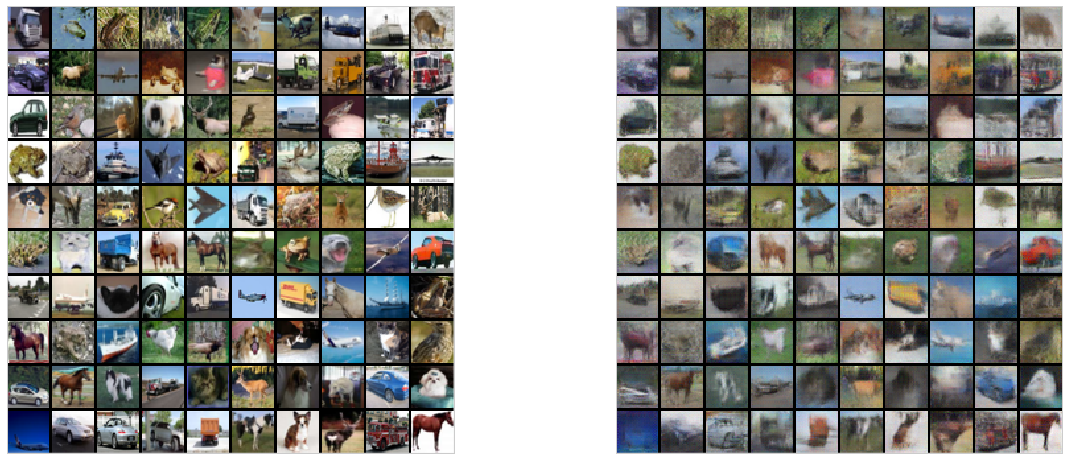

In [35]:
fig = plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(pnu.mosaic_vis(real_X.transpose(0,2,3,1), pad=2), interpolation='None')
plt.grid('off')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.subplot(1,2,2)
plt.imshow(pnu.mosaic_vis(sample_avg.transpose(0,2,3,1), pad=2), interpolation='None')
plt.grid('off')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)    

In [36]:
filename = result_dir + "synth_sample_average_%s" % sub_timestamp
fig.patch.set_alpha(0.)
fig.savefig(filename + saveext, **savearg)
plt.close()

## Multiple samples for a single condition vector

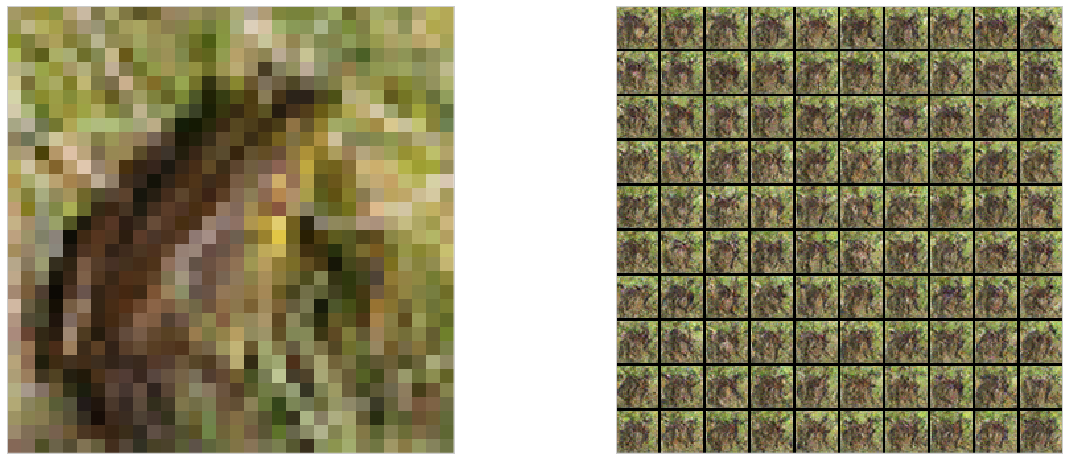

In [37]:
sampleidx = 2
fig = plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(real_X[sampleidx].transpose(1,2,0) + .5, cmap='gray', interpolation='None')
plt.grid('off')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.subplot(1,2,2)
plt.imshow(pnu.mosaic_vis(sample_Xs[:samplesize, sampleidx].transpose(0,2,3,1), pad=2), interpolation='None')
plt.grid('off')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)    

In [38]:
filename = result_dir + "synth_samples_%s" % sub_timestamp
fig.patch.set_alpha(0.)
fig.savefig(filename + saveext, **savearg)
plt.close()

In [39]:
H = entropy(sample_Xs)
C = average_correlation(sample_Xs, real_X)

print sample_Xs.shape
print H.shape
print "avg pixelwise entropy = %f, avg correlation = %f" % (np.mean(H), C)

(500, 100, 3, 32, 32)
(3, 32, 32)
avg pixelwise entropy = 0.370303, avg correlation = 0.754080


In [40]:
# encode into an mp4
#%%bash
#avconv -i '/home/styvesg/Documents/PostDoc/GitRepo/gan-imaging/reconstructions/sample_%04d.png' -r 10 synth_samples_Apr-24-2018_1220.mp4

---
# 4) Use the trained conditional generator to sample images from the validation set of the voxeldata
- The validation set is separated in two subsets 1) The part of the validation set from which the voxel noise model was inferred (test) and 2) the untouched validation set proper (gen). 
- We could perform multiple fold where an independent generator is train on each separation of the valition set into these 2 subsets.


## Multiple samples from the vim-1 voxel dataset
### 1) test set

In [41]:
gen_voxel_data = sub_dict['test']['test_voxel_data'] / sub_dict['scale']
gen_stim_data = sub_dict['test']['test_stim_data']

## Generate!

In [42]:
samplesize = len(gen_stim_data)
samplecount= 500

val_dir = cwd + "reconstruction_testset/"
if not os.path.exists(val_dir):
    os.makedirs(val_dir)
    
real_X = gen_stim_data
real_V = gen_voxel_data
#real_V = z_dist(samplesize, nv) ####

sample_Xs = []
for s in tqdm(range(samplecount)):
    sample_X = gen_true(z_dist(samplesize, nz), real_V)
    sample_Xs += [sample_X,]
    fig = plt.figure(figsize=(20,8))
    plt.subplot(1,2,1)
    plt.imshow(pnu.mosaic_vis(real_X.transpose(0,2,3,1), pad=2), interpolation='None')
    plt.clim([0,1])
    plt.grid('off')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.subplot(1,2,2)
    plt.imshow(pnu.mosaic_vis(sample_X.transpose(0,2,3,1), pad=2), interpolation='None')
    plt.grid('off')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)    
    fig.savefig(val_dir + "sample_%04d.png" % (s))
    plt.close()

100%|██████████| 500/500 [01:47<00:00,  5.01it/s]


In [43]:
sample_Xs = np.stack(sample_Xs, axis=0)
sample_mask = np.isnan(np.sum(sample_Xs, axis=(1,2,3,4)))
print "there is %d nan samples" % np.sum(sample_mask)
print sample_Xs.shape
sample_avg = np.mean(sample_Xs[~sample_mask], axis=0)
print sample_avg.shape

there is 0 nan samples
(500, 100, 3, 32, 32)
(100, 3, 32, 32)


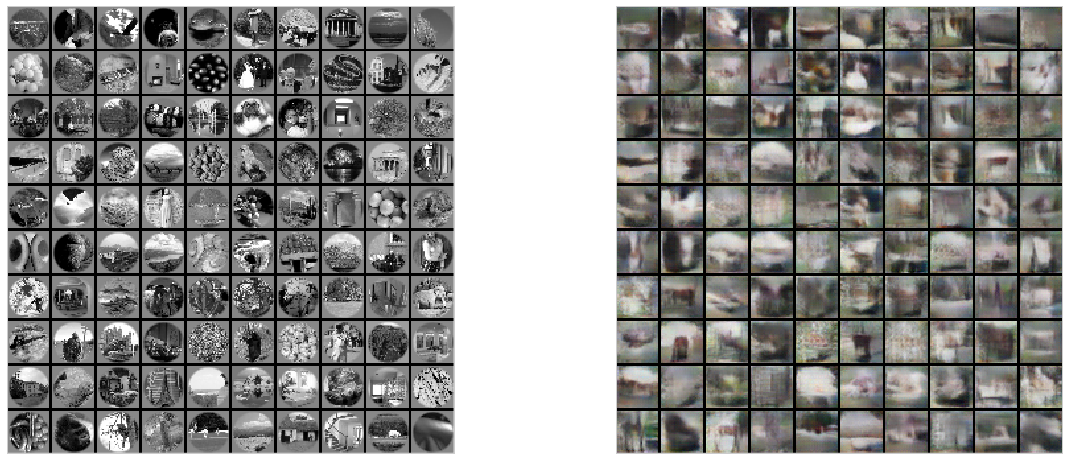

In [44]:
fig = plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(pnu.mosaic_vis(real_X.transpose(0,2,3,1), pad=2), interpolation='None')
plt.clim([0,1])
plt.grid('off')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.subplot(1,2,2)
plt.imshow(pnu.mosaic_vis(sample_avg.transpose(0,2,3,1), pad=2), interpolation='None')
plt.grid('off')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

In [45]:
filename = result_dir + "test_sample_average_%s" % sub_timestamp
fig.patch.set_alpha(0.)
fig.savefig(filename + saveext, **savearg)
plt.close()

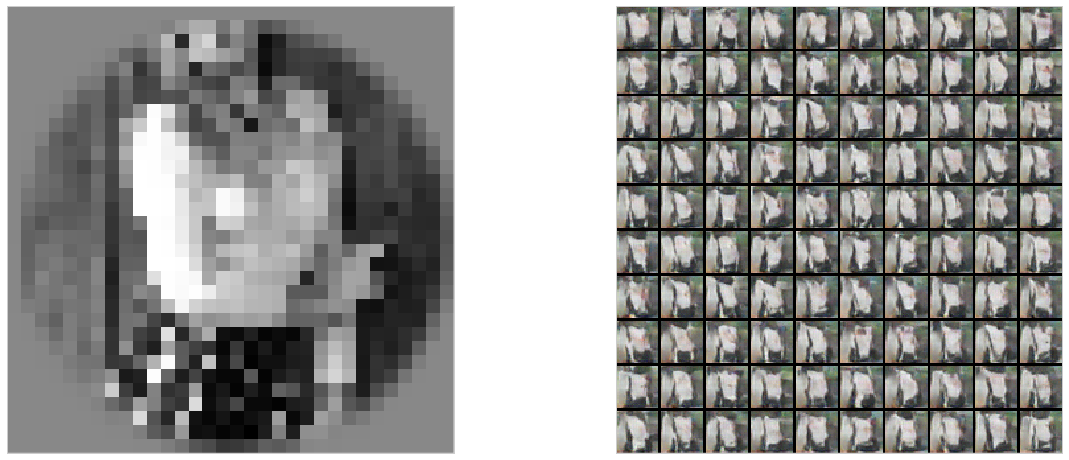

In [46]:
sampleidx = 59
fig = plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(real_X[sampleidx].transpose(1,2,0) + .5, cmap='gray', interpolation='None')
plt.grid('off')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.subplot(1,2,2)
plt.imshow(pnu.mosaic_vis(sample_Xs[:samplesize,sampleidx].transpose(0,2,3,1), pad=2), interpolation='None')
plt.grid('off')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False) 

In [47]:
filename = result_dir + "test_samples_%s" % sub_timestamp
fig.patch.set_alpha(0.)
fig.savefig(filename + saveext, **savearg)
plt.close()

In [48]:
H = entropy(sample_Xs)
C = average_correlation(sample_Xs, real_X)

print sample_Xs.shape
print H.shape
print "avg pixelwise entropy = %f, avg correlation = %f" % (np.mean(H), C)

(500, 100, 3, 32, 32)
(3, 32, 32)
avg pixelwise entropy = 0.504199, avg correlation = 0.450755


### 2) 'gen' set

In [49]:
gen_voxel_data = sub_dict['test']['gen_voxel_data'] / sub_dict['scale']
# 'scale' adjust the scale of the noise between the training and validation set.
gen_stim_data = sub_dict['test']['gen_stim_data']

## Generate!

In [50]:
samplesize = len(gen_stim_data)
samplecount= 500

val_dir = cwd + "reconstruction_genset/"
if not os.path.exists(val_dir):
    os.makedirs(val_dir)
    
real_X = gen_stim_data
real_V = gen_voxel_data
#real_V = z_dist(samplesize, nv) ####

sample_Xs = []
for s in tqdm(range(samplecount)):
    sample_X = gen_true(z_dist(samplesize, nz), real_V)
    sample_Xs += [sample_X,]
    fig = plt.figure(figsize=(20,8))
    plt.subplot(1,2,1)
    plt.imshow(pnu.mosaic_vis(real_X.transpose(0,2,3,1), pad=2), interpolation='None')
    plt.grid('off')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.subplot(1,2,2)
    plt.imshow(pnu.mosaic_vis(sample_X.transpose(0,2,3,1), pad=2), interpolation='None')
    plt.grid('off')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)    
    fig.savefig(val_dir + "sample_%04d.png" % (s))
    plt.close()

100%|██████████| 500/500 [01:06<00:00,  8.31it/s]


In [51]:
sample_Xs = np.stack(sample_Xs, axis=0)
sample_mask = np.isnan(np.sum(sample_Xs, axis=(1,2,3,4)))
print "there is %d nan samples" % np.sum(sample_mask)
print sample_Xs.shape
sample_avg = np.mean(sample_Xs[~sample_mask], axis=0)
print sample_avg.shape

there is 0 nan samples
(500, 20, 3, 32, 32)
(20, 3, 32, 32)


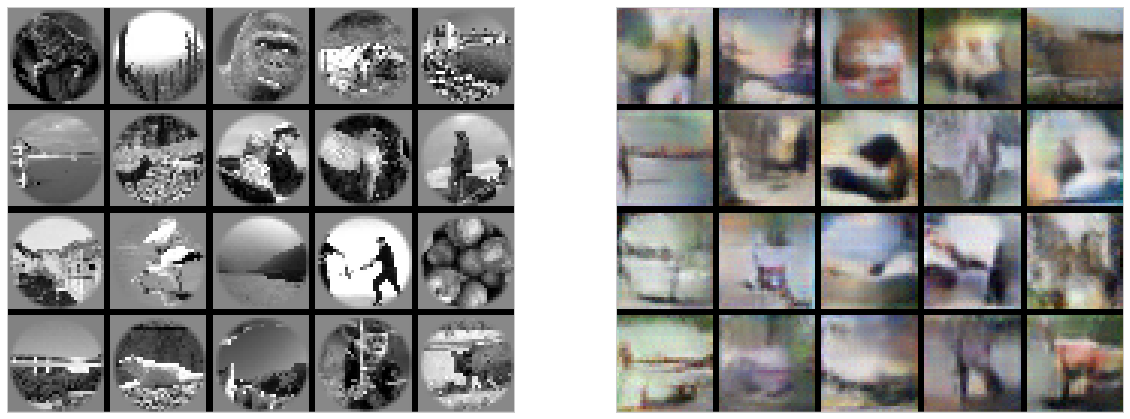

In [52]:
fig = plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(pnu.mosaic_vis(real_X.transpose(0,2,3,1), pad=2), interpolation='None')
plt.grid('off')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.subplot(1,2,2)
plt.imshow(pnu.mosaic_vis(sample_avg.transpose(0,2,3,1), pad=2), interpolation='None')
plt.grid('off')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)    

In [53]:
filename = result_dir + "gen_sample_average_%s" % sub_timestamp
fig.patch.set_alpha(0.)
fig.savefig(filename + saveext, **savearg)
plt.close()

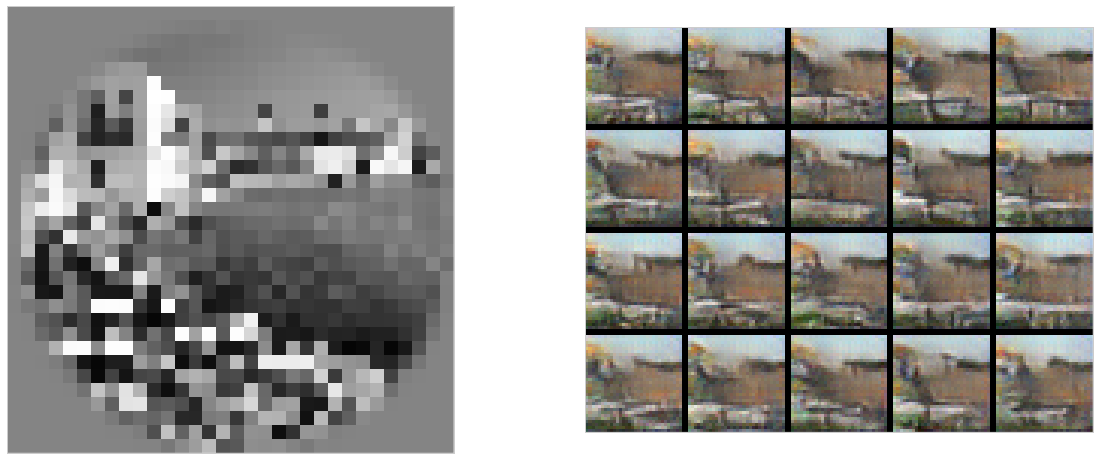

In [54]:
sampleidx = 4
fig = plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(real_X[sampleidx].transpose(1,2,0) + .5, cmap='gray', interpolation='None')
plt.grid('off')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.subplot(1,2,2)
plt.imshow(pnu.mosaic_vis(sample_Xs[:samplesize,sampleidx].transpose(0,2,3,1), pad=2), interpolation='None')
plt.grid('off')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)  

In [55]:
filename = result_dir + "gen_samples_%s" % sub_timestamp
fig.patch.set_alpha(0.)
fig.savefig(filename + saveext, **savearg)
plt.close()

In [56]:
H = entropy(sample_Xs)
C = average_correlation(sample_Xs, real_X)

print sample_Xs.shape
print H.shape
print "avg pixelwise entropy = %f, avg correlation = %f" % (np.mean(H), C)

(500, 20, 3, 32, 32)
(3, 32, 32)
avg pixelwise entropy = 0.398923, avg correlation = 0.145466


# Final notes
- To test the null hypothesis that the condition vector convey no information, we can replace the voxels (before embedding) by a sample from a gaussian distribution with the same statistics.